In [1]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
import os
import time
import numpy as np
import gc
import shutil
from tensorflow.keras.models import model_from_json
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [2]:
def scale(x):
    
    return (x - np.mean(x)) / np.std(x)

In [3]:
def preprocess(x):
    
    return x[:,:,:int(0.75*x.shape[2])]

In [4]:
path = os.getcwd()
path

'/home/llin2948/dscaptstone'

In [5]:

if not os.path.exists(path + "/Train_Data"):
    os.mkdir(path + "/Train_Data")
    os.mkdir(path + "/Train_Data/Data")
    os.mkdir(path + "/Train_Data/Labels")
    os.mkdir(path + "/Train_Data/Labels/Tau_23")
    os.mkdir(path + "/Train_Data/Labels/Tau_12")
    os.mkdir(path + "/Train_Data/Labels/Tau_13")
else:
    shutil.rmtree(path + "/Train_Data") #delete the folder
    os.mkdir(path + "/Train_Data")
    os.mkdir(path + "/Train_Data/Data")
    os.mkdir(path + "/Train_Data/Labels")
    os.mkdir(path + "/Train_Data/Labels/Heat_1")
    os.mkdir(path + "/Train_Data/Labels/Heat_2")
    os.mkdir(path + "/Train_Data/Labels/Heat_3")
    
if not os.path.exists(path + "/Saved_Models_2Sets"):
    os.mkdir(path + "/Saved_Models_2Sets")

In [6]:
all_taus = False

# 1. Generae Input datasets¶

In [7]:
counter = 1
size = 3
ini = 0
name = ['_DNS8.mat']
subdirs = ["Re15sh2_DNScoarse8","Re15sh20_DNScoarse8"]
for directory in subdirs:
    os.chdir(path + "/Data/" + directory)
    print("Reading: " + directory)
    
    # Load data and check its shape
    uname = 'u_F_xyz_T1'+name[ini]
    vname = 'v_F_xyz_T1'+name[ini]
    wname = 'w_F_xyz_T1'+name[ini]
    heat1na = 'Heat1_F_xyz_T1'+name[ini]
    heat2na = 'Heat2_F_xyz_T1'+name[ini]
    heat3na = 'Heat3_F_xyz_T1'+name[ini]
    u = preprocess(scale(loadmat(uname)["u_F"]))
    v = preprocess(scale(loadmat(vname)["v_F"]))
    w = preprocess(scale(loadmat(wname)["w_F"]))
    heat1 = preprocess(scale(loadmat(heat1na)["Heat1"]))
    heat2 = preprocess(scale(loadmat(heat2na)["Heat2"]))
    heat3 = preprocess(scale(loadmat(heat3na)["Heat3"]))
    print("Data Shape: " + str(u.shape))
    
    x = np.array([u, v, w])
    x = np.transpose(x, [1, 2, 3, 0])
    x = np.pad(x, ((size,size), (size,size), (size,size), (0,0)), 'constant', constant_values = 0)
    del u
    del v
    del w
    gc.collect()
    
    sample = []
    y_heat1 = []
    y_heat2 = []
    y_heat3 = []
    num_files = 10

    x_range = np.arange(size, x.shape[0] - size)
    np.random.shuffle(x_range)
    y_range = np.arange(size, x.shape[1] - size)
    np.random.shuffle(y_range)
    z_range = np.arange(size, x.shape[2] - size)
    np.random.shuffle(z_range)
    for i in x_range:
        for j in y_range:
            for k in z_range:
                sample.append(x[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
                y_heat1.append(heat1[i - size][j - size][k - size])
                y_heat2.append(heat2[i - size][j - size][k - size])
                y_heat3.append(heat3[i - size][j - size][k - size])

                if len(sample) == int(((x.shape[0] - size * 2) * (x.shape[1] - size * 2) * (x.shape[2] - size * 2)) / num_files):
                    os.chdir(path + "/Train_Data/Data")
                    np.save(str(counter), np.array(sample))
                    os.chdir(path + "/Train_Data/Labels/Heat_1")
                    np.save(str(counter), np.array(y_heat1))
                    os.chdir(path + "/Train_Data/Labels/Heat_2")
                    np.save(str(counter), np.array(y_heat2))
                    os.chdir(path + "/Train_Data/Labels/Heat_3")
                    np.save(str(counter), np.array(y_heat3))

                    del sample
                    del y_heat1
                    del y_heat2
                    del y_heat3
                    gc.collect()
                    sample = []
                    y_heat1 = []
                    y_heat2 = []
                    y_heat3 = []
                    
                    counter += 1
    del x
    del heat1
    del heat2
    del heat3
    gc.collect()
    print("Saved " + directory + " to disk\n")

Reading: Re15sh2_DNScoarse8
Data Shape: (146, 96, 54)
Saved Re15sh2_DNScoarse8 to disk

Reading: Re15sh20_DNScoarse8
Data Shape: (146, 96, 56)
Saved Re15sh20_DNScoarse8 to disk



# 2. Build Model¶

In [8]:
class DNN(object):
    
    def __init__(self, activation, initializer, regularizer, input_shape):
        self.activation = activation
        self.initializer = initializer
        self.regularizer = regularizer
        self.input_shape = input_shape
        
        pass 
    
    def create_model(self):
        model = keras.Sequential([
            tf.keras.layers.Flatten(input_shape = self.input_shape),
            tf.keras.layers.Dense(128, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dense(1)
        ])
        return model

# Run model

Box size used: (7, 7, 7, 3)

Predicting Heat_1

Running Dataset:Heat_1: Epoch: 0: fileSet: 4
Train on 48624 samples, validate on 12157 samples
Epoch 1/1
48624/48624 [==============================] - 2s 46us/step - loss: 1.3207 - val_loss: 1.2563

Running Dataset:Heat_1: Epoch: 0: fileSet: 16
Train on 50166 samples, validate on 12542 samples
Epoch 1/1
50166/50166 [==============================] - 1s 26us/step - loss: 0.9702 - val_loss: 0.6973

Running Dataset:Heat_1: Epoch: 0: fileSet: 10
Train on 48509 samples, validate on 12128 samples
Epoch 1/1
48509/48509 [==============================] - 1s 25us/step - loss: 1.3056 - val_loss: 1.4269

Running Dataset:Heat_1: Epoch: 0: fileSet: 6
Train on 48480 samples, validate on 12121 samples
Epoch 1/1
48480/48480 [==============================] - 1s 25us/step - loss: 1.1591 - val_loss: 1.2772

Running Dataset:Heat_1: Epoch: 0: fileSet: 15
Train on 50207 samples, validate on 12552 samples
Epoch 1/1
50207/50207 [==============================]

50254/50254 [==============================] - 1s 25us/step - loss: 0.5591 - val_loss: 0.3802

Running Dataset:Heat_1: Epoch: 2: fileSet: 4
Train on 48411 samples, validate on 12103 samples
Epoch 1/1
48411/48411 [==============================] - 1s 25us/step - loss: 0.9427 - val_loss: 0.9916

Running Dataset:Heat_1: Epoch: 2: fileSet: 15
Train on 50164 samples, validate on 12541 samples
Epoch 1/1
50164/50164 [==============================] - 1s 25us/step - loss: 0.5638 - val_loss: 0.4856

Running Dataset:Heat_1: Epoch: 2: fileSet: 6
Train on 48392 samples, validate on 12098 samples
Epoch 1/1
48392/48392 [==============================] - 1s 24us/step - loss: 0.9912 - val_loss: 1.0942

Running Dataset:Heat_1: Epoch: 2: fileSet: 17
Train on 50240 samples, validate on 12560 samples
Epoch 1/1
50240/50240 [==============================] - 1s 25us/step - loss: 0.5334 - val_loss: 0.4994

Running Dataset:Heat_1: Epoch: 2: fileSet: 16
Train on 50349 samples, validate on 12588 samples
Epoch 1

48448/48448 [==============================] - 1s 25us/step - loss: 0.8992 - val_loss: 0.8177

Running Dataset:Heat_1: Epoch: 4: fileSet: 19
Train on 50124 samples, validate on 12531 samples
Epoch 1/1
50124/50124 [==============================] - 1s 26us/step - loss: 0.4743 - val_loss: 0.5696

Running Dataset:Heat_1: Epoch: 4: fileSet: 4
Train on 48417 samples, validate on 12105 samples
Epoch 1/1
48417/48417 [==============================] - 1s 24us/step - loss: 0.9005 - val_loss: 0.9623

Running Dataset:Heat_1: Epoch: 4: fileSet: 6
Train on 48535 samples, validate on 12134 samples
Epoch 1/1
48535/48535 [==============================] - 1s 25us/step - loss: 0.8795 - val_loss: 1.0095

Running Dataset:Heat_1: Epoch: 4: fileSet: 17
Train on 50128 samples, validate on 12532 samples
Epoch 1/1
50128/50128 [==============================] - 1s 25us/step - loss: 0.5092 - val_loss: 0.5228

Running Dataset:Heat_1: Epoch: 4: fileSet: 18
Train on 50099 samples, validate on 12525 samples
Epoch 1

50080/50080 [==============================] - 1s 25us/step - loss: 0.4207 - val_loss: 0.4629

Running Dataset:Heat_1: Epoch: 6: fileSet: 4
Train on 48382 samples, validate on 12096 samples
Epoch 1/1
48382/48382 [==============================] - 1s 25us/step - loss: 0.8610 - val_loss: 0.9120

Running Dataset:Heat_1: Epoch: 6: fileSet: 5
Train on 48485 samples, validate on 12122 samples
Epoch 1/1
48485/48485 [==============================] - 1s 24us/step - loss: 0.8658 - val_loss: 0.9044

Running Dataset:Heat_1: Epoch: 6: fileSet: 10
Train on 48465 samples, validate on 12117 samples
Epoch 1/1
48465/48465 [==============================] - 1s 28us/step - loss: 0.8955 - val_loss: 1.0310

Running Dataset:Heat_1: Epoch: 6: fileSet: 18
Train on 50298 samples, validate on 12575 samples
Epoch 1/1
50298/50298 [==============================] - 1s 28us/step - loss: 0.4753 - val_loss: 0.4478

Running Dataset:Heat_1: Epoch: 6: fileSet: 8
Train on 48581 samples, validate on 12146 samples
Epoch 1/

48402/48402 [==============================] - 1s 25us/step - loss: 0.8121 - val_loss: 1.0183

Running Dataset:Heat_1: Epoch: 8: fileSet: 3
Train on 48572 samples, validate on 12144 samples
Epoch 1/1
48572/48572 [==============================] - 1s 25us/step - loss: 0.8358 - val_loss: 0.9702

Running Dataset:Heat_1: Epoch: 8: fileSet: 7
Train on 48392 samples, validate on 12099 samples
Epoch 1/1
48392/48392 [==============================] - 1s 25us/step - loss: 0.8344 - val_loss: 0.9294

Running Dataset:Heat_1: Epoch: 8: fileSet: 6
Train on 48458 samples, validate on 12115 samples
Epoch 1/1
48458/48458 [==============================] - 1s 26us/step - loss: 0.8138 - val_loss: 0.9619

Running Dataset:Heat_1: Epoch: 8: fileSet: 1
Train on 48353 samples, validate on 12089 samples
Epoch 1/1
48353/48353 [==============================] - 1s 26us/step - loss: 0.8048 - val_loss: 0.7553

Running Dataset:Heat_1: Epoch: 8: fileSet: 11
Train on 50112 samples, validate on 12529 samples
Epoch 1/1

48528/48528 [==============================] - 1s 25us/step - loss: 0.7805 - val_loss: 0.8495

Running Dataset:Heat_1: Epoch: 10: fileSet: 15
Train on 50364 samples, validate on 12591 samples
Epoch 1/1
50364/50364 [==============================] - 1s 25us/step - loss: 0.3845 - val_loss: 0.4133

Running Dataset:Heat_1: Epoch: 10: fileSet: 4
Train on 48461 samples, validate on 12116 samples
Epoch 1/1
48461/48461 [==============================] - 1s 24us/step - loss: 0.7921 - val_loss: 0.8638

Running Dataset:Heat_1: Epoch: 10: fileSet: 8
Train on 48556 samples, validate on 12139 samples
Epoch 1/1
48556/48556 [==============================] - 1s 25us/step - loss: 0.7513 - val_loss: 0.9585

Running Dataset:Heat_1: Epoch: 10: fileSet: 3
Train on 48384 samples, validate on 12096 samples
Epoch 1/1
48384/48384 [==============================] - 1s 25us/step - loss: 0.8275 - val_loss: 0.9188

Running Dataset:Heat_1: Epoch: 10: fileSet: 7
Train on 48497 samples, validate on 12125 samples
Epoc

Train on 50229 samples, validate on 12558 samples
Epoch 1/1
50229/50229 [==============================] - 1s 26us/step - loss: 0.3803 - val_loss: 0.3767

Running Dataset:Heat_1: Epoch: 12: fileSet: 3
Train on 48289 samples, validate on 12073 samples
Epoch 1/1
48289/48289 [==============================] - 1s 24us/step - loss: 0.7996 - val_loss: 0.9451

Running Dataset:Heat_1: Epoch: 12: fileSet: 12
Train on 50244 samples, validate on 12561 samples
Epoch 1/1
50244/50244 [==============================] - 1s 23us/step - loss: 0.3802 - val_loss: 0.3985

Running Dataset:Heat_1: Epoch: 12: fileSet: 14
Train on 50167 samples, validate on 12542 samples
Epoch 1/1
50167/50167 [==============================] - 1s 24us/step - loss: 0.4007 - val_loss: 0.4547

Running Dataset:Heat_1: Epoch: 12: fileSet: 1
Train on 48585 samples, validate on 12147 samples
Epoch 1/1
48585/48585 [==============================] - 1s 26us/step - loss: 0.7956 - val_loss: 0.7378

Running Dataset:Heat_1: Epoch: 12: file


Running Dataset:Heat_1: Epoch: 14: fileSet: 13
Train on 50383 samples, validate on 12596 samples
Epoch 1/1
50383/50383 [==============================] - 1s 25us/step - loss: 0.3510 - val_loss: 0.4133

Running Dataset:Heat_1: Epoch: 14: fileSet: 14
Train on 50186 samples, validate on 12547 samples
Epoch 1/1
50186/50186 [==============================] - 1s 24us/step - loss: 0.3638 - val_loss: 0.3749

Running Dataset:Heat_1: Epoch: 14: fileSet: 6
Train on 48436 samples, validate on 12109 samples
Epoch 1/1
48436/48436 [==============================] - 1s 24us/step - loss: 0.7779 - val_loss: 0.9351

Running Dataset:Heat_1: Epoch: 14: fileSet: 5
Train on 48636 samples, validate on 12160 samples
Epoch 1/1
48636/48636 [==============================] - 1s 25us/step - loss: 0.7807 - val_loss: 0.8717

Running Dataset:Heat_1: Epoch: 14: fileSet: 16
Train on 50231 samples, validate on 12558 samples
Epoch 1/1
50231/50231 [==============================] - 1s 25us/step - loss: 0.3665 - val_loss:

50288/50288 [==============================] - 1s 25us/step - loss: 0.3945 - val_loss: 0.4244

Running Dataset:Heat_1: Epoch: 16: fileSet: 16
Train on 50336 samples, validate on 12584 samples
Epoch 1/1
50336/50336 [==============================] - 1s 25us/step - loss: 0.3629 - val_loss: 0.4935

Running Dataset:Heat_1: Epoch: 16: fileSet: 12
Train on 50156 samples, validate on 12540 samples
Epoch 1/1
50156/50156 [==============================] - 1s 25us/step - loss: 0.3616 - val_loss: 0.3834

Running Dataset:Heat_1: Epoch: 16: fileSet: 5
Train on 48305 samples, validate on 12077 samples
Epoch 1/1
48305/48305 [==============================] - 1s 25us/step - loss: 0.7929 - val_loss: 0.8547

Running Dataset:Heat_1: Epoch: 16: fileSet: 14
Train on 50283 samples, validate on 12571 samples
Epoch 1/1
50283/50283 [==============================] - 1s 24us/step - loss: 0.3908 - val_loss: 0.3606

Running Dataset:Heat_1: Epoch: 16: fileSet: 11
Train on 50196 samples, validate on 12549 samples
E

Train on 48509 samples, validate on 12128 samples
Epoch 1/1
48509/48509 [==============================] - 1s 24us/step - loss: 0.7724 - val_loss: 0.7423

Running Dataset:Heat_1: Epoch: 18: fileSet: 7
Train on 48485 samples, validate on 12122 samples
Epoch 1/1
48485/48485 [==============================] - 1s 25us/step - loss: 0.7412 - val_loss: 0.8476

Running Dataset:Heat_1: Epoch: 18: fileSet: 16
Train on 50216 samples, validate on 12555 samples
Epoch 1/1
50216/50216 [==============================] - 1s 24us/step - loss: 0.3670 - val_loss: 0.4383

Running Dataset:Heat_1: Epoch: 18: fileSet: 12
Train on 50352 samples, validate on 12588 samples
Epoch 1/1
50352/50352 [==============================] - 1s 24us/step - loss: 0.3313 - val_loss: 0.3513

Running Dataset:Heat_1: Epoch: 18: fileSet: 17
Train on 50147 samples, validate on 12537 samples
Epoch 1/1
50147/50147 [==============================] - 1s 24us/step - loss: 0.3455 - val_loss: 0.4570

Running Dataset:Heat_1: Epoch: 18: fil

50336/50336 [==============================] - 1s 25us/step - loss: 0.3190 - val_loss: 0.3813

Running Dataset:Heat_1: Epoch: 20: fileSet: 14
Train on 50335 samples, validate on 12584 samples
Epoch 1/1
50335/50335 [==============================] - 1s 25us/step - loss: 0.3245 - val_loss: 0.3631

Running Dataset:Heat_1: Epoch: 20: fileSet: 8
Train on 48408 samples, validate on 12102 samples
Epoch 1/1
48408/48408 [==============================] - 1s 25us/step - loss: 0.7427 - val_loss: 0.9458

Running Dataset:Heat_1: Epoch: 20: fileSet: 10
Train on 48538 samples, validate on 12135 samples
Epoch 1/1
48538/48538 [==============================] - 1s 25us/step - loss: 0.7845 - val_loss: 0.9827

Running Dataset:Heat_1: Epoch: 20: fileSet: 13
Train on 50340 samples, validate on 12586 samples
Epoch 1/1
50340/50340 [==============================] - 1s 25us/step - loss: 0.3260 - val_loss: 0.4626

Running Dataset:Heat_1: Epoch: 20: fileSet: 9
Train on 48596 samples, validate on 12149 samples
Ep

Train on 48356 samples, validate on 12090 samples
Epoch 1/1
48356/48356 [==============================] - 1s 26us/step - loss: 0.7336 - val_loss: 0.9144

Running Dataset:Heat_1: Epoch: 22: fileSet: 11
Train on 50424 samples, validate on 12607 samples
Epoch 1/1
50424/50424 [==============================] - 1s 25us/step - loss: 0.3677 - val_loss: 0.4721

Running Dataset:Heat_1: Epoch: 22: fileSet: 6
Train on 48389 samples, validate on 12098 samples
Epoch 1/1
48389/48389 [==============================] - 1s 28us/step - loss: 0.7497 - val_loss: 0.9277

Running Dataset:Heat_1: Epoch: 22: fileSet: 19
Train on 50210 samples, validate on 12553 samples
Epoch 1/1
50210/50210 [==============================] - 1s 29us/step - loss: 0.3451 - val_loss: 0.4492

Running Dataset:Heat_1: Epoch: 22: fileSet: 9
Train on 48373 samples, validate on 12094 samples
Epoch 1/1
48373/48373 [==============================] - 1s 25us/step - loss: 0.7627 - val_loss: 0.7611

Running Dataset:Heat_1: Epoch: 22: file

48440/48440 [==============================] - 1s 25us/step - loss: 0.7103 - val_loss: 0.8082

Running Dataset:Heat_1: Epoch: 24: fileSet: 5
Train on 48356 samples, validate on 12089 samples
Epoch 1/1
48356/48356 [==============================] - 1s 26us/step - loss: 0.7275 - val_loss: 0.8449

Running Dataset:Heat_1: Epoch: 24: fileSet: 8
Train on 48312 samples, validate on 12078 samples
Epoch 1/1
48312/48312 [==============================] - 1s 25us/step - loss: 0.6898 - val_loss: 0.9108

Running Dataset:Heat_1: Epoch: 24: fileSet: 13
Train on 50428 samples, validate on 12607 samples
Epoch 1/1
50428/50428 [==============================] - 1s 26us/step - loss: 0.3238 - val_loss: 0.3936

Running Dataset:Heat_1: Epoch: 24: fileSet: 17
Train on 50342 samples, validate on 12586 samples
Epoch 1/1
50342/50342 [==============================] - 1s 26us/step - loss: 0.3251 - val_loss: 0.4278

Running Dataset:Heat_1: Epoch: 24: fileSet: 1
Train on 48406 samples, validate on 12102 samples
Epo

Train on 48385 samples, validate on 12097 samples
Epoch 1/1
48385/48385 [==============================] - 1s 25us/step - loss: 0.7322 - val_loss: 0.8252

Running Dataset:Heat_1: Epoch: 26: fileSet: 16
Train on 50350 samples, validate on 12588 samples
Epoch 1/1
50350/50350 [==============================] - 1s 25us/step - loss: 0.3703 - val_loss: 0.3976

Running Dataset:Heat_1: Epoch: 26: fileSet: 4
Train on 48415 samples, validate on 12104 samples
Epoch 1/1
48415/48415 [==============================] - 1s 25us/step - loss: 0.7222 - val_loss: 0.8198

Running Dataset:Heat_1: Epoch: 26: fileSet: 7
Train on 48455 samples, validate on 12114 samples
Epoch 1/1
48455/48455 [==============================] - 1s 25us/step - loss: 0.7251 - val_loss: 0.8758

Running Dataset:Heat_1: Epoch: 26: fileSet: 9
Train on 48356 samples, validate on 12089 samples
Epoch 1/1
48356/48356 [==============================] - 1s 25us/step - loss: 0.7364 - val_loss: 0.7486

Running Dataset:Heat_1: Epoch: 26: fileS


Running Dataset:Heat_1: Epoch: 28: fileSet: 14
Train on 50305 samples, validate on 12577 samples
Epoch 1/1
50305/50305 [==============================] - 1s 28us/step - loss: 0.3457 - val_loss: 0.3644

Running Dataset:Heat_1: Epoch: 28: fileSet: 3
Train on 48579 samples, validate on 12145 samples
Epoch 1/1
48579/48579 [==============================] - 1s 27us/step - loss: 0.7506 - val_loss: 0.8455

Running Dataset:Heat_1: Epoch: 28: fileSet: 15
Train on 50263 samples, validate on 12566 samples
Epoch 1/1
50263/50263 [==============================] - 1s 25us/step - loss: 0.3267 - val_loss: 0.4314

Running Dataset:Heat_1: Epoch: 28: fileSet: 17
Train on 50145 samples, validate on 12537 samples
Epoch 1/1
50145/50145 [==============================] - 1s 25us/step - loss: 0.3225 - val_loss: 0.3627

Running Dataset:Heat_1: Epoch: 28: fileSet: 9
Train on 48369 samples, validate on 12093 samples
Epoch 1/1
48369/48369 [==============================] - 1s 25us/step - loss: 0.7525 - val_loss:

50258/50258 [==============================] - 1s 24us/step - loss: 0.3130 - val_loss: 0.3905

Running Dataset:Heat_1: Epoch: 30: fileSet: 20
Train on 50151 samples, validate on 12538 samples
Epoch 1/1
50151/50151 [==============================] - 1s 24us/step - loss: 0.3040 - val_loss: 0.3150

Running Dataset:Heat_1: Epoch: 30: fileSet: 15
Train on 50282 samples, validate on 12571 samples
Epoch 1/1
50282/50282 [==============================] - 1s 25us/step - loss: 0.2898 - val_loss: 0.3853

Running Dataset:Heat_1: Epoch: 30: fileSet: 7
Train on 48324 samples, validate on 12081 samples
Epoch 1/1
48324/48324 [==============================] - 1s 25us/step - loss: 0.7331 - val_loss: 0.8974

Running Dataset:Heat_1: Epoch: 30: fileSet: 17
Train on 50167 samples, validate on 12542 samples
Epoch 1/1
50167/50167 [==============================] - 1s 25us/step - loss: 0.3253 - val_loss: 0.4054

Running Dataset:Heat_1: Epoch: 30: fileSet: 9
Train on 48464 samples, validate on 12117 samples
Ep

Train on 48400 samples, validate on 12100 samples
Epoch 1/1
48400/48400 [==============================] - 1s 24us/step - loss: 0.7277 - val_loss: 0.8106

Running Dataset:Heat_1: Epoch: 32: fileSet: 4
Train on 48496 samples, validate on 12124 samples
Epoch 1/1
48496/48496 [==============================] - 1s 24us/step - loss: 0.6864 - val_loss: 0.7954

Running Dataset:Heat_1: Epoch: 32: fileSet: 12
Train on 50139 samples, validate on 12535 samples
Epoch 1/1
50139/50139 [==============================] - 1s 25us/step - loss: 0.3356 - val_loss: 0.3580

Running Dataset:Heat_1: Epoch: 32: fileSet: 17
Train on 50311 samples, validate on 12578 samples
Epoch 1/1
50311/50311 [==============================] - 1s 25us/step - loss: 0.3118 - val_loss: 0.3835

Running Dataset:Heat_1: Epoch: 32: fileSet: 2
Train on 48557 samples, validate on 12140 samples
Epoch 1/1
48557/48557 [==============================] - 1s 23us/step - loss: 0.6848 - val_loss: 0.7772

Running Dataset:Heat_1: Epoch: 32: file


Running Dataset:Heat_1: Epoch: 34: fileSet: 13
Train on 50175 samples, validate on 12544 samples
Epoch 1/1
50175/50175 [==============================] - 1s 25us/step - loss: 0.2945 - val_loss: 0.3721

Running Dataset:Heat_1: Epoch: 34: fileSet: 16
Train on 50284 samples, validate on 12571 samples
Epoch 1/1
50284/50284 [==============================] - 1s 24us/step - loss: 0.3106 - val_loss: 0.3704

Running Dataset:Heat_1: Epoch: 34: fileSet: 3
Train on 48356 samples, validate on 12090 samples
Epoch 1/1
48356/48356 [==============================] - 1s 25us/step - loss: 0.7324 - val_loss: 0.8443

Running Dataset:Heat_1: Epoch: 34: fileSet: 2
Train on 48380 samples, validate on 12095 samples
Epoch 1/1
48380/48380 [==============================] - 1s 24us/step - loss: 0.6771 - val_loss: 0.7755

Running Dataset:Heat_1: Epoch: 34: fileSet: 8
Train on 48447 samples, validate on 12112 samples
Epoch 1/1
48447/48447 [==============================] - 1s 25us/step - loss: 0.6768 - val_loss: 

48579/48579 [==============================] - 1s 25us/step - loss: 0.7020 - val_loss: 0.9124

Running Dataset:Heat_1: Epoch: 36: fileSet: 5
Train on 48406 samples, validate on 12102 samples
Epoch 1/1
48406/48406 [==============================] - 1s 26us/step - loss: 0.7095 - val_loss: 0.8300

Running Dataset:Heat_1: Epoch: 36: fileSet: 2
Train on 48420 samples, validate on 12106 samples
Epoch 1/1
48420/48420 [==============================] - 1s 25us/step - loss: 0.6830 - val_loss: 0.7962

Running Dataset:Heat_1: Epoch: 36: fileSet: 18
Train on 50240 samples, validate on 12560 samples
Epoch 1/1
50240/50240 [==============================] - 1s 25us/step - loss: 0.3522 - val_loss: 0.3597

Running Dataset:Heat_1: Epoch: 36: fileSet: 12
Train on 50324 samples, validate on 12582 samples
Epoch 1/1
50324/50324 [==============================] - 1s 24us/step - loss: 0.3062 - val_loss: 0.4111

Running Dataset:Heat_1: Epoch: 36: fileSet: 14
Train on 50148 samples, validate on 12537 samples
Ep

Train on 50228 samples, validate on 12557 samples
Epoch 1/1
50228/50228 [==============================] - 1s 25us/step - loss: 0.3115 - val_loss: 0.4780

Running Dataset:Heat_1: Epoch: 38: fileSet: 8
Train on 48324 samples, validate on 12081 samples
Epoch 1/1
48324/48324 [==============================] - 1s 25us/step - loss: 0.6709 - val_loss: 0.8993

Running Dataset:Heat_1: Epoch: 38: fileSet: 3
Train on 48461 samples, validate on 12116 samples
Epoch 1/1
48461/48461 [==============================] - 1s 25us/step - loss: 0.7155 - val_loss: 0.8428

Running Dataset:Heat_1: Epoch: 38: fileSet: 1
Train on 48580 samples, validate on 12146 samples
Epoch 1/1
48580/48580 [==============================] - 1s 25us/step - loss: 0.6762 - val_loss: 0.7133

Running Dataset:Heat_1: Epoch: 38: fileSet: 16
Train on 50240 samples, validate on 12561 samples
Epoch 1/1
50240/50240 [==============================] - 1s 24us/step - loss: 0.3194 - val_loss: 0.3656

Running Dataset:Heat_1: Epoch: 38: fileS


Running Dataset:Heat_1: Epoch: 40: fileSet: 5
Train on 48362 samples, validate on 12091 samples
Epoch 1/1
48362/48362 [==============================] - 1s 24us/step - loss: 0.7309 - val_loss: 0.8230

Running Dataset:Heat_1: Epoch: 40: fileSet: 2
Train on 48324 samples, validate on 12081 samples
Epoch 1/1
48324/48324 [==============================] - 1s 24us/step - loss: 0.6651 - val_loss: 0.7718

Running Dataset:Heat_1: Epoch: 40: fileSet: 13
Train on 50248 samples, validate on 12562 samples
Epoch 1/1
50248/50248 [==============================] - 1s 25us/step - loss: 0.2856 - val_loss: 0.3988

Running Dataset:Heat_1: Epoch: 40: fileSet: 20
Train on 50290 samples, validate on 12573 samples
Epoch 1/1
50290/50290 [==============================] - 1s 24us/step - loss: 0.2956 - val_loss: 0.3159

Running Dataset:Heat_1: Epoch: 40: fileSet: 15
Train on 50409 samples, validate on 12603 samples
Epoch 1/1
50409/50409 [==============================] - 1s 24us/step - loss: 0.2787 - val_loss:

48435/48435 [==============================] - 1s 24us/step - loss: 0.6755 - val_loss: 0.8680

Running Dataset:Heat_1: Epoch: 42: fileSet: 3
Train on 48356 samples, validate on 12090 samples
Epoch 1/1
48356/48356 [==============================] - 1s 23us/step - loss: 0.7045 - val_loss: 0.8354

Running Dataset:Heat_1: Epoch: 42: fileSet: 13
Train on 50236 samples, validate on 12559 samples
Epoch 1/1
50236/50236 [==============================] - 1s 24us/step - loss: 0.2906 - val_loss: 0.3705

Running Dataset:Heat_1: Epoch: 42: fileSet: 2
Train on 48512 samples, validate on 12129 samples
Epoch 1/1
48512/48512 [==============================] - 1s 25us/step - loss: 0.6852 - val_loss: 0.7714

Running Dataset:Heat_1: Epoch: 42: fileSet: 1
Train on 48580 samples, validate on 12146 samples
Epoch 1/1
48580/48580 [==============================] - 1s 24us/step - loss: 0.6818 - val_loss: 0.7031

Running Dataset:Heat_1: Epoch: 42: fileSet: 20
Train on 50165 samples, validate on 12542 samples
Epo

Train on 48481 samples, validate on 12121 samples
Epoch 1/1
48481/48481 [==============================] - 1s 24us/step - loss: 0.6771 - val_loss: 0.8027

Running Dataset:Heat_1: Epoch: 44: fileSet: 13
Train on 50308 samples, validate on 12577 samples
Epoch 1/1
50308/50308 [==============================] - 1s 25us/step - loss: 0.2735 - val_loss: 0.3882

Running Dataset:Heat_1: Epoch: 44: fileSet: 6
Train on 48324 samples, validate on 12082 samples
Epoch 1/1
48324/48324 [==============================] - 1s 24us/step - loss: 0.6863 - val_loss: 0.8788

Running Dataset:Heat_1: Epoch: 44: fileSet: 9
Train on 48479 samples, validate on 12120 samples
Epoch 1/1
48479/48479 [==============================] - 1s 25us/step - loss: 0.7060 - val_loss: 0.7443

Running Dataset:Heat_1: Epoch: 44: fileSet: 10
Train on 48500 samples, validate on 12125 samples
Epoch 1/1
48500/48500 [==============================] - 1s 25us/step - loss: 0.7225 - val_loss: 0.9126

Running Dataset:Heat_1: Epoch: 45: file


Running Dataset:Heat_1: Epoch: 46: fileSet: 13
Train on 50142 samples, validate on 12536 samples
Epoch 1/1
50142/50142 [==============================] - 1s 25us/step - loss: 0.2861 - val_loss: 0.4359

Running Dataset:Heat_1: Epoch: 46: fileSet: 18
Train on 50131 samples, validate on 12533 samples
Epoch 1/1
50131/50131 [==============================] - 1s 25us/step - loss: 0.3114 - val_loss: 0.3956

Running Dataset:Heat_1: Epoch: 46: fileSet: 15
Train on 50226 samples, validate on 12557 samples
Epoch 1/1
50226/50226 [==============================] - 1s 25us/step - loss: 0.2717 - val_loss: 0.3846

Running Dataset:Heat_1: Epoch: 46: fileSet: 8
Train on 48520 samples, validate on 12131 samples
Epoch 1/1
48520/48520 [==============================] - 1s 25us/step - loss: 0.6706 - val_loss: 0.8947

Running Dataset:Heat_1: Epoch: 47: fileSet: 16
Train on 50286 samples, validate on 12572 samples
Epoch 1/1
50286/50286 [==============================] - 1s 24us/step - loss: 0.2944 - val_loss

50176/50176 [==============================] - 1s 28us/step - loss: 0.3149 - val_loss: 0.4270

Running Dataset:Heat_1: Epoch: 48: fileSet: 20
Train on 50241 samples, validate on 12561 samples
Epoch 1/1
50241/50241 [==============================] - 1s 27us/step - loss: 0.2921 - val_loss: 0.3098

Running Dataset:Heat_1: Epoch: 48: fileSet: 15
Train on 50248 samples, validate on 12563 samples
Epoch 1/1
50248/50248 [==============================] - 1s 26us/step - loss: 0.2696 - val_loss: 0.3982

Running Dataset:Heat_1: Epoch: 48: fileSet: 3
Train on 48433 samples, validate on 12109 samples
Epoch 1/1
48433/48433 [==============================] - 1s 25us/step - loss: 0.7185 - val_loss: 0.8645

Running Dataset:Heat_1: Epoch: 49: fileSet: 15
Train on 50318 samples, validate on 12580 samples
Epoch 1/1
50318/50318 [==============================] - 1s 25us/step - loss: 0.2750 - val_loss: 0.3599

Running Dataset:Heat_1: Epoch: 49: fileSet: 6
Train on 48577 samples, validate on 12145 samples
Ep


Running Dataset:Heat_2: Epoch: 0: fileSet: 3
Train on 48522 samples, validate on 12131 samples
Epoch 1/1
48522/48522 [==============================] - 1s 25us/step - loss: 1.0024 - val_loss: 0.8525

Running Dataset:Heat_2: Epoch: 0: fileSet: 8
Train on 48372 samples, validate on 12094 samples
Epoch 1/1
48372/48372 [==============================] - 1s 25us/step - loss: 0.9693 - val_loss: 0.9994

Running Dataset:Heat_2: Epoch: 0: fileSet: 17
Train on 50244 samples, validate on 12561 samples
Epoch 1/1
50244/50244 [==============================] - 1s 24us/step - loss: 0.9778 - val_loss: 0.9406

Running Dataset:Heat_2: Epoch: 1: fileSet: 18
Train on 50468 samples, validate on 12618 samples
Epoch 1/1
50468/50468 [==============================] - 1s 25us/step - loss: 0.9392 - val_loss: 0.7551

Running Dataset:Heat_2: Epoch: 1: fileSet: 7
Train on 48392 samples, validate on 12098 samples
Epoch 1/1
48392/48392 [==============================] - 1s 25us/step - loss: 0.9503 - val_loss: 0.993

50151/50151 [==============================] - 1s 25us/step - loss: 0.8582 - val_loss: 0.9067

Running Dataset:Heat_2: Epoch: 2: fileSet: 18
Train on 50124 samples, validate on 12532 samples
Epoch 1/1
50124/50124 [==============================] - 1s 25us/step - loss: 0.8596 - val_loss: 0.7483

Running Dataset:Heat_2: Epoch: 2: fileSet: 5
Train on 48337 samples, validate on 12085 samples
Epoch 1/1
48337/48337 [==============================] - 1s 27us/step - loss: 0.8859 - val_loss: 0.9625

Running Dataset:Heat_2: Epoch: 3: fileSet: 20
Train on 50380 samples, validate on 12596 samples
Epoch 1/1
50380/50380 [==============================] - 1s 25us/step - loss: 0.8636 - val_loss: 0.8189

Running Dataset:Heat_2: Epoch: 3: fileSet: 1
Train on 48562 samples, validate on 12141 samples
Epoch 1/1
48562/48562 [==============================] - 1s 24us/step - loss: 0.9400 - val_loss: 0.8717

Running Dataset:Heat_2: Epoch: 3: fileSet: 3
Train on 48463 samples, validate on 12116 samples
Epoch 1/

48536/48536 [==============================] - 1s 28us/step - loss: 0.8498 - val_loss: 0.7720

Running Dataset:Heat_2: Epoch: 4: fileSet: 16
Train on 50080 samples, validate on 12521 samples
Epoch 1/1
50080/50080 [==============================] - 1s 29us/step - loss: 0.7966 - val_loss: 0.8015

Running Dataset:Heat_2: Epoch: 5: fileSet: 18
Train on 50281 samples, validate on 12571 samples
Epoch 1/1
50281/50281 [==============================] - 1s 25us/step - loss: 0.7514 - val_loss: 0.7119

Running Dataset:Heat_2: Epoch: 5: fileSet: 2
Train on 48383 samples, validate on 12096 samples
Epoch 1/1
48383/48383 [==============================] - 1s 26us/step - loss: 0.8321 - val_loss: 0.8969

Running Dataset:Heat_2: Epoch: 5: fileSet: 10
Train on 48561 samples, validate on 12141 samples
Epoch 1/1
48561/48561 [==============================] - 1s 24us/step - loss: 0.8364 - val_loss: 0.9496

Running Dataset:Heat_2: Epoch: 5: fileSet: 4
Train on 48373 samples, validate on 12094 samples
Epoch 1

48547/48547 [==============================] - 1s 24us/step - loss: 0.7677 - val_loss: 0.8480

Running Dataset:Heat_2: Epoch: 7: fileSet: 15
Train on 50245 samples, validate on 12562 samples
Epoch 1/1
50245/50245 [==============================] - 1s 25us/step - loss: 0.7238 - val_loss: 0.8167

Running Dataset:Heat_2: Epoch: 7: fileSet: 3
Train on 48417 samples, validate on 12105 samples
Epoch 1/1
48417/48417 [==============================] - 1s 28us/step - loss: 0.8074 - val_loss: 0.7456

Running Dataset:Heat_2: Epoch: 7: fileSet: 1
Train on 48351 samples, validate on 12088 samples
Epoch 1/1
48351/48351 [==============================] - 1s 25us/step - loss: 0.8232 - val_loss: 0.8437

Running Dataset:Heat_2: Epoch: 7: fileSet: 12
Train on 50311 samples, validate on 12578 samples
Epoch 1/1
50311/50311 [==============================] - 1s 24us/step - loss: 0.8083 - val_loss: 0.7776

Running Dataset:Heat_2: Epoch: 7: fileSet: 11
Train on 50273 samples, validate on 12569 samples
Epoch 1

48510/48510 [==============================] - 1s 28us/step - loss: 0.8167 - val_loss: 0.8071

Running Dataset:Heat_2: Epoch: 9: fileSet: 5
Train on 48400 samples, validate on 12100 samples
Epoch 1/1
48400/48400 [==============================] - 1s 27us/step - loss: 0.7432 - val_loss: 0.8882

Running Dataset:Heat_2: Epoch: 9: fileSet: 16
Train on 50225 samples, validate on 12557 samples
Epoch 1/1
50225/50225 [==============================] - 1s 26us/step - loss: 0.7339 - val_loss: 0.7626

Running Dataset:Heat_2: Epoch: 9: fileSet: 13
Train on 50232 samples, validate on 12558 samples
Epoch 1/1
50232/50232 [==============================] - 1s 24us/step - loss: 0.7388 - val_loss: 0.6386

Running Dataset:Heat_2: Epoch: 9: fileSet: 2
Train on 48410 samples, validate on 12103 samples
Epoch 1/1
48410/48410 [==============================] - 1s 25us/step - loss: 0.7780 - val_loss: 0.8429

Running Dataset:Heat_2: Epoch: 9: fileSet: 14
Train on 50219 samples, validate on 12555 samples
Epoch 1

48444/48444 [==============================] - 1s 24us/step - loss: 0.7171 - val_loss: 0.8498

Running Dataset:Heat_2: Epoch: 11: fileSet: 8
Train on 48587 samples, validate on 12147 samples
Epoch 1/1
48587/48587 [==============================] - 1s 28us/step - loss: 0.7156 - val_loss: 0.8356

Running Dataset:Heat_2: Epoch: 11: fileSet: 5
Train on 48426 samples, validate on 12107 samples
Epoch 1/1
48426/48426 [==============================] - 1s 28us/step - loss: 0.7158 - val_loss: 0.8823

Running Dataset:Heat_2: Epoch: 11: fileSet: 1
Train on 48533 samples, validate on 12134 samples
Epoch 1/1
48533/48533 [==============================] - 1s 25us/step - loss: 0.7535 - val_loss: 0.8221

Running Dataset:Heat_2: Epoch: 11: fileSet: 9
Train on 48272 samples, validate on 12068 samples
Epoch 1/1
48272/48272 [==============================] - 1s 25us/step - loss: 0.7943 - val_loss: 0.7760

Running Dataset:Heat_2: Epoch: 11: fileSet: 17
Train on 50192 samples, validate on 12549 samples
Epoc

Train on 48631 samples, validate on 12158 samples
Epoch 1/1
48631/48631 [==============================] - 1s 24us/step - loss: 0.7657 - val_loss: 0.7392

Running Dataset:Heat_2: Epoch: 13: fileSet: 1
Train on 48580 samples, validate on 12145 samples
Epoch 1/1
48580/48580 [==============================] - 1s 27us/step - loss: 0.7520 - val_loss: 0.7801

Running Dataset:Heat_2: Epoch: 13: fileSet: 17
Train on 50369 samples, validate on 12593 samples
Epoch 1/1
50369/50369 [==============================] - 1s 28us/step - loss: 0.7012 - val_loss: 0.8879

Running Dataset:Heat_2: Epoch: 13: fileSet: 7
Train on 48310 samples, validate on 12078 samples
Epoch 1/1
48310/48310 [==============================] - 1s 27us/step - loss: 0.7262 - val_loss: 0.8705

Running Dataset:Heat_2: Epoch: 13: fileSet: 4
Train on 48443 samples, validate on 12111 samples
Epoch 1/1
48443/48443 [==============================] - 1s 25us/step - loss: 0.6995 - val_loss: 0.7985

Running Dataset:Heat_2: Epoch: 13: fileS

48444/48444 [==============================] - 1s 25us/step - loss: 0.6870 - val_loss: 0.8350

Running Dataset:Heat_2: Epoch: 15: fileSet: 5
Train on 48419 samples, validate on 12105 samples
Epoch 1/1
48419/48419 [==============================] - 1s 25us/step - loss: 0.7244 - val_loss: 0.8769

Running Dataset:Heat_2: Epoch: 15: fileSet: 17
Train on 50316 samples, validate on 12580 samples
Epoch 1/1
50316/50316 [==============================] - 1s 27us/step - loss: 0.7119 - val_loss: 0.8563

Running Dataset:Heat_2: Epoch: 15: fileSet: 9
Train on 48419 samples, validate on 12105 samples
Epoch 1/1
48419/48419 [==============================] - 1s 28us/step - loss: 0.7697 - val_loss: 0.7607

Running Dataset:Heat_2: Epoch: 15: fileSet: 14
Train on 50300 samples, validate on 12575 samples
Epoch 1/1
50300/50300 [==============================] - 1s 25us/step - loss: 0.6806 - val_loss: 0.7812

Running Dataset:Heat_2: Epoch: 15: fileSet: 16
Train on 50220 samples, validate on 12555 samples
Ep

Train on 48328 samples, validate on 12082 samples
Epoch 1/1
48328/48328 [==============================] - 1s 25us/step - loss: 0.7643 - val_loss: 0.7463

Running Dataset:Heat_2: Epoch: 17: fileSet: 19
Train on 50248 samples, validate on 12563 samples
Epoch 1/1
50248/50248 [==============================] - 1s 25us/step - loss: 0.7057 - val_loss: 0.7558

Running Dataset:Heat_2: Epoch: 17: fileSet: 15
Train on 50222 samples, validate on 12556 samples
Epoch 1/1
50222/50222 [==============================] - 1s 25us/step - loss: 0.6392 - val_loss: 0.8131

Running Dataset:Heat_2: Epoch: 17: fileSet: 12
Train on 50396 samples, validate on 12600 samples
Epoch 1/1
50396/50396 [==============================] - 2s 31us/step - loss: 0.6938 - val_loss: 0.7220

Running Dataset:Heat_2: Epoch: 17: fileSet: 2
Train on 48458 samples, validate on 12115 samples
Epoch 1/1
48458/48458 [==============================] - 1s 29us/step - loss: 0.7397 - val_loss: 0.8256

Running Dataset:Heat_2: Epoch: 17: fil


Running Dataset:Heat_2: Epoch: 19: fileSet: 4
Train on 48520 samples, validate on 12131 samples
Epoch 1/1
48520/48520 [==============================] - 1s 25us/step - loss: 0.6620 - val_loss: 0.8000

Running Dataset:Heat_2: Epoch: 19: fileSet: 14
Train on 50187 samples, validate on 12547 samples
Epoch 1/1
50187/50187 [==============================] - 1s 29us/step - loss: 0.6614 - val_loss: 0.7858

Running Dataset:Heat_2: Epoch: 19: fileSet: 12
Train on 49914 samples, validate on 12479 samples
Epoch 1/1
49914/49914 [==============================] - 1s 26us/step - loss: 0.7017 - val_loss: 0.7080

Running Dataset:Heat_2: Epoch: 19: fileSet: 9
Train on 48429 samples, validate on 12108 samples
Epoch 1/1
48429/48429 [==============================] - 1s 26us/step - loss: 0.7669 - val_loss: 0.7673

Running Dataset:Heat_2: Epoch: 19: fileSet: 5
Train on 48324 samples, validate on 12081 samples
Epoch 1/1
48324/48324 [==============================] - 1s 24us/step - loss: 0.7203 - val_loss: 

50325/50325 [==============================] - 1s 25us/step - loss: 0.6798 - val_loss: 0.6979

Running Dataset:Heat_2: Epoch: 21: fileSet: 17
Train on 50264 samples, validate on 12566 samples
Epoch 1/1
50264/50264 [==============================] - 1s 24us/step - loss: 0.6778 - val_loss: 0.7855

Running Dataset:Heat_2: Epoch: 21: fileSet: 7
Train on 48453 samples, validate on 12114 samples
Epoch 1/1
48453/48453 [==============================] - 1s 25us/step - loss: 0.6934 - val_loss: 0.8132

Running Dataset:Heat_2: Epoch: 21: fileSet: 11
Train on 50186 samples, validate on 12547 samples
Epoch 1/1
50186/50186 [==============================] - 1s 27us/step - loss: 0.6308 - val_loss: 0.8296

Running Dataset:Heat_2: Epoch: 21: fileSet: 8
Train on 48458 samples, validate on 12115 samples
Epoch 1/1
48458/48458 [==============================] - 1s 29us/step - loss: 0.6813 - val_loss: 0.8242

Running Dataset:Heat_2: Epoch: 21: fileSet: 16
Train on 50224 samples, validate on 12557 samples
Ep

Train on 48506 samples, validate on 12127 samples
Epoch 1/1
48506/48506 [==============================] - 1s 24us/step - loss: 0.6973 - val_loss: 0.7815

Running Dataset:Heat_2: Epoch: 23: fileSet: 10
Train on 48461 samples, validate on 12116 samples
Epoch 1/1
48461/48461 [==============================] - 1s 28us/step - loss: 0.7147 - val_loss: 0.9324

Running Dataset:Heat_2: Epoch: 23: fileSet: 9
Train on 48432 samples, validate on 12108 samples
Epoch 1/1
48432/48432 [==============================] - 1s 25us/step - loss: 0.7219 - val_loss: 0.7873

Running Dataset:Heat_2: Epoch: 23: fileSet: 15
Train on 50360 samples, validate on 12591 samples
Epoch 1/1
50360/50360 [==============================] - 1s 25us/step - loss: 0.6257 - val_loss: 0.7587

Running Dataset:Heat_2: Epoch: 23: fileSet: 2
Train on 48332 samples, validate on 12083 samples
Epoch 1/1
48332/48332 [==============================] - 1s 25us/step - loss: 0.7050 - val_loss: 0.8369

Running Dataset:Heat_2: Epoch: 23: file


Running Dataset:Heat_2: Epoch: 25: fileSet: 7
Train on 48500 samples, validate on 12125 samples
Epoch 1/1
48500/48500 [==============================] - 1s 25us/step - loss: 0.6810 - val_loss: 0.7555

Running Dataset:Heat_2: Epoch: 25: fileSet: 18
Train on 50039 samples, validate on 12510 samples
Epoch 1/1
50039/50039 [==============================] - 1s 24us/step - loss: 0.6431 - val_loss: 0.6575

Running Dataset:Heat_2: Epoch: 25: fileSet: 8
Train on 48543 samples, validate on 12136 samples
Epoch 1/1
48543/48543 [==============================] - 1s 25us/step - loss: 0.6773 - val_loss: 0.7952

Running Dataset:Heat_2: Epoch: 25: fileSet: 19
Train on 50261 samples, validate on 12566 samples
Epoch 1/1
50261/50261 [==============================] - 1s 25us/step - loss: 0.6819 - val_loss: 0.6933

Running Dataset:Heat_2: Epoch: 25: fileSet: 10
Train on 48436 samples, validate on 12109 samples
Epoch 1/1
48436/48436 [==============================] - 1s 25us/step - loss: 0.7096 - val_loss:

50204/50204 [==============================] - 1s 25us/step - loss: 0.6212 - val_loss: 0.6018

Running Dataset:Heat_2: Epoch: 27: fileSet: 16
Train on 50177 samples, validate on 12545 samples
Epoch 1/1
50177/50177 [==============================] - 1s 24us/step - loss: 0.6356 - val_loss: 0.6864

Running Dataset:Heat_2: Epoch: 27: fileSet: 13
Train on 50327 samples, validate on 12582 samples
Epoch 1/1
50327/50327 [==============================] - 1s 27us/step - loss: 0.6036 - val_loss: 0.5995

Running Dataset:Heat_2: Epoch: 27: fileSet: 1
Train on 48396 samples, validate on 12100 samples
Epoch 1/1
48396/48396 [==============================] - 1s 29us/step - loss: 0.7100 - val_loss: 0.7580

Running Dataset:Heat_2: Epoch: 27: fileSet: 9
Train on 48462 samples, validate on 12116 samples
Epoch 1/1
48462/48462 [==============================] - 1s 25us/step - loss: 0.7286 - val_loss: 0.7481

Running Dataset:Heat_2: Epoch: 27: fileSet: 11
Train on 50144 samples, validate on 12537 samples
Ep

Train on 50257 samples, validate on 12565 samples
Epoch 1/1
50257/50257 [==============================] - 1s 25us/step - loss: 0.6069 - val_loss: 0.8302

Running Dataset:Heat_2: Epoch: 29: fileSet: 3
Train on 48354 samples, validate on 12089 samples
Epoch 1/1
48354/48354 [==============================] - 1s 25us/step - loss: 0.6931 - val_loss: 0.7487

Running Dataset:Heat_2: Epoch: 29: fileSet: 5
Train on 48392 samples, validate on 12099 samples
Epoch 1/1
48392/48392 [==============================] - 1s 24us/step - loss: 0.6813 - val_loss: 0.8529

Running Dataset:Heat_2: Epoch: 29: fileSet: 18
Train on 50286 samples, validate on 12572 samples
Epoch 1/1
50286/50286 [==============================] - 1s 25us/step - loss: 0.6267 - val_loss: 0.5958

Running Dataset:Heat_2: Epoch: 29: fileSet: 14
Train on 50046 samples, validate on 12512 samples
Epoch 1/1
50046/50046 [==============================] - 1s 25us/step - loss: 0.6269 - val_loss: 0.7748

Running Dataset:Heat_2: Epoch: 29: file


Running Dataset:Heat_2: Epoch: 31: fileSet: 8
Train on 48508 samples, validate on 12128 samples
Epoch 1/1
48508/48508 [==============================] - 1s 23us/step - loss: 0.6600 - val_loss: 0.7679

Running Dataset:Heat_2: Epoch: 31: fileSet: 6
Train on 48572 samples, validate on 12144 samples
Epoch 1/1
48572/48572 [==============================] - 1s 25us/step - loss: 0.6743 - val_loss: 0.7842

Running Dataset:Heat_2: Epoch: 31: fileSet: 13
Train on 50076 samples, validate on 12519 samples
Epoch 1/1
50076/50076 [==============================] - 1s 25us/step - loss: 0.6147 - val_loss: 0.5893

Running Dataset:Heat_2: Epoch: 31: fileSet: 19
Train on 50023 samples, validate on 12506 samples
Epoch 1/1
50023/50023 [==============================] - 1s 27us/step - loss: 0.6522 - val_loss: 0.7193

Running Dataset:Heat_2: Epoch: 31: fileSet: 20
Train on 50268 samples, validate on 12568 samples
Epoch 1/1
50268/50268 [==============================] - 1s 23us/step - loss: 0.6698 - val_loss:

48503/48503 [==============================] - 1s 24us/step - loss: 0.6962 - val_loss: 0.7950

Running Dataset:Heat_2: Epoch: 33: fileSet: 11
Train on 50372 samples, validate on 12594 samples
Epoch 1/1
50372/50372 [==============================] - 1s 24us/step - loss: 0.5971 - val_loss: 0.7947

Running Dataset:Heat_2: Epoch: 33: fileSet: 6
Train on 48418 samples, validate on 12105 samples
Epoch 1/1
48418/48418 [==============================] - 1s 24us/step - loss: 0.6665 - val_loss: 0.7829

Running Dataset:Heat_2: Epoch: 33: fileSet: 10
Train on 48340 samples, validate on 12086 samples
Epoch 1/1
48340/48340 [==============================] - 1s 25us/step - loss: 0.6815 - val_loss: 0.8843

Running Dataset:Heat_2: Epoch: 33: fileSet: 7
Train on 48488 samples, validate on 12123 samples
Epoch 1/1
48488/48488 [==============================] - 1s 24us/step - loss: 0.6549 - val_loss: 0.8121

Running Dataset:Heat_2: Epoch: 33: fileSet: 17
Train on 50142 samples, validate on 12536 samples
Ep

Train on 48528 samples, validate on 12133 samples
Epoch 1/1
48528/48528 [==============================] - 1s 24us/step - loss: 0.7028 - val_loss: 0.8887

Running Dataset:Heat_2: Epoch: 35: fileSet: 1
Train on 48508 samples, validate on 12128 samples
Epoch 1/1
48508/48508 [==============================] - 1s 24us/step - loss: 0.6906 - val_loss: 0.7850

Running Dataset:Heat_2: Epoch: 35: fileSet: 16
Train on 50283 samples, validate on 12571 samples
Epoch 1/1
50283/50283 [==============================] - 1s 25us/step - loss: 0.6139 - val_loss: 0.6345

Running Dataset:Heat_2: Epoch: 35: fileSet: 15
Train on 50268 samples, validate on 12568 samples
Epoch 1/1
50268/50268 [==============================] - 1s 25us/step - loss: 0.5968 - val_loss: 0.7540

Running Dataset:Heat_2: Epoch: 35: fileSet: 12
Train on 50248 samples, validate on 12563 samples
Epoch 1/1
50248/50248 [==============================] - 1s 25us/step - loss: 0.6476 - val_loss: 0.6669

Running Dataset:Heat_2: Epoch: 35: fil


Running Dataset:Heat_2: Epoch: 37: fileSet: 1
Train on 48401 samples, validate on 12101 samples
Epoch 1/1
48401/48401 [==============================] - 1s 25us/step - loss: 0.6823 - val_loss: 0.7430

Running Dataset:Heat_2: Epoch: 37: fileSet: 13
Train on 50046 samples, validate on 12512 samples
Epoch 1/1
50046/50046 [==============================] - 1s 25us/step - loss: 0.5803 - val_loss: 0.5839

Running Dataset:Heat_2: Epoch: 37: fileSet: 12
Train on 50283 samples, validate on 12571 samples
Epoch 1/1
50283/50283 [==============================] - 1s 24us/step - loss: 0.6338 - val_loss: 0.6722

Running Dataset:Heat_2: Epoch: 37: fileSet: 7
Train on 48461 samples, validate on 12116 samples
Epoch 1/1
48461/48461 [==============================] - 1s 24us/step - loss: 0.6509 - val_loss: 0.8309

Running Dataset:Heat_2: Epoch: 37: fileSet: 9
Train on 48424 samples, validate on 12107 samples
Epoch 1/1
48424/48424 [==============================] - 1s 24us/step - loss: 0.7042 - val_loss: 

50332/50332 [==============================] - 1s 26us/step - loss: 0.6288 - val_loss: 0.8271

Running Dataset:Heat_2: Epoch: 39: fileSet: 12
Train on 50365 samples, validate on 12592 samples
Epoch 1/1
50365/50365 [==============================] - 1s 24us/step - loss: 0.6279 - val_loss: 0.6762

Running Dataset:Heat_2: Epoch: 39: fileSet: 7
Train on 48416 samples, validate on 12105 samples
Epoch 1/1
48416/48416 [==============================] - 1s 25us/step - loss: 0.6472 - val_loss: 0.7589

Running Dataset:Heat_2: Epoch: 39: fileSet: 16
Train on 50285 samples, validate on 12572 samples
Epoch 1/1
50285/50285 [==============================] - 1s 25us/step - loss: 0.5964 - val_loss: 0.6702

Running Dataset:Heat_2: Epoch: 39: fileSet: 14
Train on 50152 samples, validate on 12539 samples
Epoch 1/1
50152/50152 [==============================] - 1s 25us/step - loss: 0.6057 - val_loss: 0.7123

Running Dataset:Heat_2: Epoch: 39: fileSet: 6
Train on 48400 samples, validate on 12101 samples
Ep

Train on 50144 samples, validate on 12536 samples
Epoch 1/1
50144/50144 [==============================] - 1s 24us/step - loss: 0.6216 - val_loss: 0.6876

Running Dataset:Heat_2: Epoch: 41: fileSet: 11
Train on 50284 samples, validate on 12571 samples
Epoch 1/1
50284/50284 [==============================] - 1s 25us/step - loss: 0.5880 - val_loss: 0.8506

Running Dataset:Heat_2: Epoch: 41: fileSet: 2
Train on 48484 samples, validate on 12122 samples
Epoch 1/1
48484/48484 [==============================] - 1s 24us/step - loss: 0.6609 - val_loss: 0.8395

Running Dataset:Heat_2: Epoch: 41: fileSet: 8
Train on 48578 samples, validate on 12145 samples
Epoch 1/1
48578/48578 [==============================] - 1s 24us/step - loss: 0.6371 - val_loss: 0.7941

Running Dataset:Heat_2: Epoch: 41: fileSet: 12
Train on 50151 samples, validate on 12538 samples
Epoch 1/1
50151/50151 [==============================] - 1s 25us/step - loss: 0.6454 - val_loss: 0.6527

Running Dataset:Heat_2: Epoch: 41: file


Running Dataset:Heat_2: Epoch: 43: fileSet: 3
Train on 48423 samples, validate on 12106 samples
Epoch 1/1
48423/48423 [==============================] - 1s 25us/step - loss: 0.6849 - val_loss: 0.7433

Running Dataset:Heat_2: Epoch: 43: fileSet: 17
Train on 50136 samples, validate on 12534 samples
Epoch 1/1
50136/50136 [==============================] - 1s 25us/step - loss: 0.6333 - val_loss: 0.7576

Running Dataset:Heat_2: Epoch: 43: fileSet: 6
Train on 48354 samples, validate on 12089 samples
Epoch 1/1
48354/48354 [==============================] - 1s 25us/step - loss: 0.6557 - val_loss: 0.7907

Running Dataset:Heat_2: Epoch: 43: fileSet: 2
Train on 48496 samples, validate on 12124 samples
Epoch 1/1
48496/48496 [==============================] - 1s 25us/step - loss: 0.6718 - val_loss: 0.8232

Running Dataset:Heat_2: Epoch: 43: fileSet: 14
Train on 50064 samples, validate on 12516 samples
Epoch 1/1
50064/50064 [==============================] - 1s 25us/step - loss: 0.6118 - val_loss: 

50100/50100 [==============================] - 1s 24us/step - loss: 0.6001 - val_loss: 0.6697

Running Dataset:Heat_2: Epoch: 45: fileSet: 10
Train on 48371 samples, validate on 12093 samples
Epoch 1/1
48371/48371 [==============================] - 1s 25us/step - loss: 0.6859 - val_loss: 0.8646

Running Dataset:Heat_2: Epoch: 45: fileSet: 3
Train on 48349 samples, validate on 12088 samples
Epoch 1/1
48349/48349 [==============================] - 1s 26us/step - loss: 0.6855 - val_loss: 0.7359

Running Dataset:Heat_2: Epoch: 45: fileSet: 4
Train on 48563 samples, validate on 12141 samples
Epoch 1/1
48563/48563 [==============================] - 1s 25us/step - loss: 0.6402 - val_loss: 0.7954

Running Dataset:Heat_2: Epoch: 45: fileSet: 8
Train on 48343 samples, validate on 12086 samples
Epoch 1/1
48343/48343 [==============================] - 1s 24us/step - loss: 0.6397 - val_loss: 0.8167

Running Dataset:Heat_2: Epoch: 45: fileSet: 6
Train on 48370 samples, validate on 12093 samples
Epoc

Train on 50280 samples, validate on 12571 samples
Epoch 1/1
50280/50280 [==============================] - 1s 25us/step - loss: 0.5350 - val_loss: 0.6129

Running Dataset:Heat_2: Epoch: 47: fileSet: 11
Train on 50251 samples, validate on 12563 samples
Epoch 1/1
50251/50251 [==============================] - 1s 25us/step - loss: 0.5742 - val_loss: 0.8585

Running Dataset:Heat_2: Epoch: 47: fileSet: 16
Train on 50159 samples, validate on 12540 samples
Epoch 1/1
50159/50159 [==============================] - 1s 24us/step - loss: 0.6097 - val_loss: 0.6199

Running Dataset:Heat_2: Epoch: 47: fileSet: 2
Train on 48384 samples, validate on 12097 samples
Epoch 1/1
48384/48384 [==============================] - 1s 25us/step - loss: 0.6566 - val_loss: 0.8039

Running Dataset:Heat_2: Epoch: 47: fileSet: 1
Train on 48400 samples, validate on 12101 samples
Epoch 1/1
48400/48400 [==============================] - 1s 25us/step - loss: 0.6771 - val_loss: 0.7548

Running Dataset:Heat_2: Epoch: 47: file


Running Dataset:Heat_2: Epoch: 49: fileSet: 16
Train on 50249 samples, validate on 12563 samples
Epoch 1/1
50249/50249 [==============================] - 1s 25us/step - loss: 0.5912 - val_loss: 0.6595

Running Dataset:Heat_2: Epoch: 49: fileSet: 4
Train on 48599 samples, validate on 12150 samples
Epoch 1/1
48599/48599 [==============================] - 1s 25us/step - loss: 0.6401 - val_loss: 0.7704

Running Dataset:Heat_2: Epoch: 49: fileSet: 10
Train on 48479 samples, validate on 12120 samples
Epoch 1/1
48479/48479 [==============================] - 1s 25us/step - loss: 0.6829 - val_loss: 0.8616

Running Dataset:Heat_2: Epoch: 49: fileSet: 18
Train on 50188 samples, validate on 12548 samples
Epoch 1/1
50188/50188 [==============================] - 1s 25us/step - loss: 0.5847 - val_loss: 0.6045

Running Dataset:Heat_2: Epoch: 49: fileSet: 1
Train on 48466 samples, validate on 12117 samples
Epoch 1/1
48466/48466 [==============================] - 1s 26us/step - loss: 0.6559 - val_loss:

48427/48427 [==============================] - 1s 25us/step - loss: 0.5459 - val_loss: 0.4791

Running Dataset:Heat_3: Epoch: 1: fileSet: 14
Train on 50259 samples, validate on 12565 samples
Epoch 1/1
50259/50259 [==============================] - 1s 25us/step - loss: 0.5778 - val_loss: 0.5850

Running Dataset:Heat_3: Epoch: 1: fileSet: 10
Train on 48224 samples, validate on 12057 samples
Epoch 1/1
48224/48224 [==============================] - 1s 24us/step - loss: 0.5754 - val_loss: 0.7028

Running Dataset:Heat_3: Epoch: 1: fileSet: 18
Train on 50312 samples, validate on 12579 samples
Epoch 1/1
50312/50312 [==============================] - 1s 27us/step - loss: 0.5595 - val_loss: 0.5449

Running Dataset:Heat_3: Epoch: 1: fileSet: 11
Train on 50098 samples, validate on 12525 samples
Epoch 1/1
50098/50098 [==============================] - 1s 27us/step - loss: 0.5011 - val_loss: 0.6102

Running Dataset:Heat_3: Epoch: 1: fileSet: 17
Train on 50283 samples, validate on 12571 samples
Epoch

50221/50221 [==============================] - 1s 24us/step - loss: 0.5254 - val_loss: 0.6103

Running Dataset:Heat_3: Epoch: 3: fileSet: 20
Train on 50118 samples, validate on 12530 samples
Epoch 1/1
50118/50118 [==============================] - 1s 25us/step - loss: 0.4849 - val_loss: 0.4445

Running Dataset:Heat_3: Epoch: 3: fileSet: 2
Train on 48544 samples, validate on 12137 samples
Epoch 1/1
48544/48544 [==============================] - 1s 25us/step - loss: 0.5036 - val_loss: 0.6036

Running Dataset:Heat_3: Epoch: 3: fileSet: 19
Train on 50223 samples, validate on 12556 samples
Epoch 1/1
50223/50223 [==============================] - 1s 25us/step - loss: 0.4898 - val_loss: 0.6168

Running Dataset:Heat_3: Epoch: 3: fileSet: 12
Train on 50327 samples, validate on 12582 samples
Epoch 1/1
50327/50327 [==============================] - 1s 25us/step - loss: 0.4919 - val_loss: 0.4653

Running Dataset:Heat_3: Epoch: 4: fileSet: 3
Train on 48334 samples, validate on 12084 samples
Epoch 1

48461/48461 [==============================] - 1s 27us/step - loss: 0.4275 - val_loss: 0.5009

Running Dataset:Heat_3: Epoch: 5: fileSet: 19
Train on 50219 samples, validate on 12555 samples
Epoch 1/1
50219/50219 [==============================] - 1s 29us/step - loss: 0.4729 - val_loss: 0.5681

Running Dataset:Heat_3: Epoch: 5: fileSet: 8
Train on 48413 samples, validate on 12104 samples
Epoch 1/1
48413/48413 [==============================] - 1s 25us/step - loss: 0.3973 - val_loss: 0.4805

Running Dataset:Heat_3: Epoch: 5: fileSet: 14
Train on 50268 samples, validate on 12567 samples
Epoch 1/1
50268/50268 [==============================] - 1s 24us/step - loss: 0.5101 - val_loss: 0.5904

Running Dataset:Heat_3: Epoch: 6: fileSet: 2
Train on 48436 samples, validate on 12110 samples
Epoch 1/1
48436/48436 [==============================] - 1s 25us/step - loss: 0.4487 - val_loss: 0.5672

Running Dataset:Heat_3: Epoch: 6: fileSet: 8
Train on 48435 samples, validate on 12109 samples
Epoch 1/

50256/50256 [==============================] - 1s 26us/step - loss: 0.4599 - val_loss: 0.4874

Running Dataset:Heat_3: Epoch: 7: fileSet: 18
Train on 50188 samples, validate on 12547 samples
Epoch 1/1
50188/50188 [==============================] - 1s 25us/step - loss: 0.4600 - val_loss: 0.4963

Running Dataset:Heat_3: Epoch: 7: fileSet: 10
Train on 48538 samples, validate on 12135 samples
Epoch 1/1
48538/48538 [==============================] - 1s 25us/step - loss: 0.4860 - val_loss: 0.6094

Running Dataset:Heat_3: Epoch: 8: fileSet: 17
Train on 50221 samples, validate on 12556 samples
Epoch 1/1
50221/50221 [==============================] - 1s 24us/step - loss: 0.4315 - val_loss: 0.4933

Running Dataset:Heat_3: Epoch: 8: fileSet: 8
Train on 48514 samples, validate on 12129 samples
Epoch 1/1
48514/48514 [==============================] - 1s 25us/step - loss: 0.3902 - val_loss: 0.5265

Running Dataset:Heat_3: Epoch: 8: fileSet: 14
Train on 50204 samples, validate on 12551 samples
Epoch 

48416/48416 [==============================] - 1s 25us/step - loss: 0.3994 - val_loss: 0.4998

Running Dataset:Heat_3: Epoch: 9: fileSet: 20
Train on 50187 samples, validate on 12547 samples
Epoch 1/1
50187/50187 [==============================] - 1s 24us/step - loss: 0.4514 - val_loss: 0.4680

Running Dataset:Heat_3: Epoch: 10: fileSet: 12
Train on 50016 samples, validate on 12505 samples
Epoch 1/1
50016/50016 [==============================] - 1s 24us/step - loss: 0.4312 - val_loss: 0.4488

Running Dataset:Heat_3: Epoch: 10: fileSet: 5
Train on 48521 samples, validate on 12131 samples
Epoch 1/1
48521/48521 [==============================] - 1s 25us/step - loss: 0.3992 - val_loss: 0.5294

Running Dataset:Heat_3: Epoch: 10: fileSet: 10
Train on 48455 samples, validate on 12114 samples
Epoch 1/1
48455/48455 [==============================] - 1s 25us/step - loss: 0.4180 - val_loss: 0.6369

Running Dataset:Heat_3: Epoch: 10: fileSet: 13
Train on 50164 samples, validate on 12541 samples
Ep

Train on 49976 samples, validate on 12494 samples
Epoch 1/1
49976/49976 [==============================] - 1s 26us/step - loss: 0.4231 - val_loss: 0.4487

Running Dataset:Heat_3: Epoch: 12: fileSet: 13
Train on 50267 samples, validate on 12567 samples
Epoch 1/1
50267/50267 [==============================] - 1s 25us/step - loss: 0.3772 - val_loss: 0.4652

Running Dataset:Heat_3: Epoch: 12: fileSet: 17
Train on 50277 samples, validate on 12570 samples
Epoch 1/1
50277/50277 [==============================] - 1s 25us/step - loss: 0.4043 - val_loss: 0.4598

Running Dataset:Heat_3: Epoch: 12: fileSet: 4
Train on 48444 samples, validate on 12112 samples
Epoch 1/1
48444/48444 [==============================] - 1s 25us/step - loss: 0.3769 - val_loss: 0.4740

Running Dataset:Heat_3: Epoch: 12: fileSet: 5
Train on 48480 samples, validate on 12120 samples
Epoch 1/1
48480/48480 [==============================] - 1s 25us/step - loss: 0.3748 - val_loss: 0.5205

Running Dataset:Heat_3: Epoch: 12: file


Running Dataset:Heat_3: Epoch: 14: fileSet: 1
Train on 48464 samples, validate on 12116 samples
Epoch 1/1
48464/48464 [==============================] - 1s 25us/step - loss: 0.3872 - val_loss: 0.4307

Running Dataset:Heat_3: Epoch: 14: fileSet: 20
Train on 50268 samples, validate on 12567 samples
Epoch 1/1
50268/50268 [==============================] - 1s 26us/step - loss: 0.4123 - val_loss: 0.4889

Running Dataset:Heat_3: Epoch: 14: fileSet: 6
Train on 48400 samples, validate on 12100 samples
Epoch 1/1
48400/48400 [==============================] - 1s 26us/step - loss: 0.3885 - val_loss: 0.5550

Running Dataset:Heat_3: Epoch: 14: fileSet: 16
Train on 50348 samples, validate on 12588 samples
Epoch 1/1
50348/50348 [==============================] - 1s 25us/step - loss: 0.4106 - val_loss: 0.4538

Running Dataset:Heat_3: Epoch: 14: fileSet: 10
Train on 48574 samples, validate on 12144 samples
Epoch 1/1
48574/48574 [==============================] - 1s 25us/step - loss: 0.4201 - val_loss:

50212/50212 [==============================] - 1s 25us/step - loss: 0.3828 - val_loss: 0.5746

Running Dataset:Heat_3: Epoch: 16: fileSet: 15
Train on 50294 samples, validate on 12574 samples
Epoch 1/1
50294/50294 [==============================] - 1s 25us/step - loss: 0.3845 - val_loss: 0.5058

Running Dataset:Heat_3: Epoch: 16: fileSet: 11
Train on 50358 samples, validate on 12590 samples
Epoch 1/1
50358/50358 [==============================] - 1s 26us/step - loss: 0.3725 - val_loss: 0.5489

Running Dataset:Heat_3: Epoch: 16: fileSet: 2
Train on 48500 samples, validate on 12126 samples
Epoch 1/1
48500/48500 [==============================] - 1s 25us/step - loss: 0.3705 - val_loss: 0.5322

Running Dataset:Heat_3: Epoch: 16: fileSet: 4
Train on 48513 samples, validate on 12129 samples
Epoch 1/1
48513/48513 [==============================] - 1s 26us/step - loss: 0.3448 - val_loss: 0.4717

Running Dataset:Heat_3: Epoch: 16: fileSet: 10
Train on 48425 samples, validate on 12107 samples
Ep

Train on 50271 samples, validate on 12568 samples
Epoch 1/1
50271/50271 [==============================] - 1s 25us/step - loss: 0.3834 - val_loss: 0.4548

Running Dataset:Heat_3: Epoch: 18: fileSet: 14
Train on 50192 samples, validate on 12548 samples
Epoch 1/1
50192/50192 [==============================] - 1s 24us/step - loss: 0.3875 - val_loss: 0.5325

Running Dataset:Heat_3: Epoch: 18: fileSet: 9
Train on 48303 samples, validate on 12076 samples
Epoch 1/1
48303/48303 [==============================] - 1s 25us/step - loss: 0.4063 - val_loss: 0.4431

Running Dataset:Heat_3: Epoch: 18: fileSet: 6
Train on 48438 samples, validate on 12110 samples
Epoch 1/1
48438/48438 [==============================] - 1s 24us/step - loss: 0.3752 - val_loss: 0.5666

Running Dataset:Heat_3: Epoch: 18: fileSet: 11
Train on 50290 samples, validate on 12573 samples
Epoch 1/1
50290/50290 [==============================] - 1s 25us/step - loss: 0.3969 - val_loss: 0.5669

Running Dataset:Heat_3: Epoch: 18: file


Running Dataset:Heat_3: Epoch: 20: fileSet: 6
Train on 48444 samples, validate on 12111 samples
Epoch 1/1
48444/48444 [==============================] - 1s 26us/step - loss: 0.3702 - val_loss: 0.5439

Running Dataset:Heat_3: Epoch: 20: fileSet: 17
Train on 50206 samples, validate on 12552 samples
Epoch 1/1
50206/50206 [==============================] - 1s 26us/step - loss: 0.3825 - val_loss: 0.4971

Running Dataset:Heat_3: Epoch: 20: fileSet: 4
Train on 48356 samples, validate on 12090 samples
Epoch 1/1
48356/48356 [==============================] - 1s 26us/step - loss: 0.3310 - val_loss: 0.4648

Running Dataset:Heat_3: Epoch: 20: fileSet: 20
Train on 50306 samples, validate on 12577 samples
Epoch 1/1
50306/50306 [==============================] - 1s 28us/step - loss: 0.4039 - val_loss: 0.4399

Running Dataset:Heat_3: Epoch: 20: fileSet: 16
Train on 50135 samples, validate on 12534 samples
Epoch 1/1
50135/50135 [==============================] - 1s 28us/step - loss: 0.3858 - val_loss:

50050/50050 [==============================] - 1s 25us/step - loss: 0.3855 - val_loss: 0.4030

Running Dataset:Heat_3: Epoch: 22: fileSet: 1
Train on 48604 samples, validate on 12151 samples
Epoch 1/1
48604/48604 [==============================] - 1s 24us/step - loss: 0.3923 - val_loss: 0.4627

Running Dataset:Heat_3: Epoch: 22: fileSet: 19
Train on 50172 samples, validate on 12543 samples
Epoch 1/1
50172/50172 [==============================] - 1s 26us/step - loss: 0.3788 - val_loss: 0.5501

Running Dataset:Heat_3: Epoch: 22: fileSet: 10
Train on 48529 samples, validate on 12133 samples
Epoch 1/1
48529/48529 [==============================] - 1s 25us/step - loss: 0.3884 - val_loss: 0.6142

Running Dataset:Heat_3: Epoch: 22: fileSet: 14
Train on 50272 samples, validate on 12569 samples
Epoch 1/1
50272/50272 [==============================] - 1s 24us/step - loss: 0.4000 - val_loss: 0.5246

Running Dataset:Heat_3: Epoch: 22: fileSet: 2
Train on 48350 samples, validate on 12088 samples
Ep

Train on 48376 samples, validate on 12095 samples
Epoch 1/1
48376/48376 [==============================] - 1s 25us/step - loss: 0.3146 - val_loss: 0.4840

Running Dataset:Heat_3: Epoch: 24: fileSet: 18
Train on 50145 samples, validate on 12537 samples
Epoch 1/1
50145/50145 [==============================] - 1s 28us/step - loss: 0.3950 - val_loss: 0.4419

Running Dataset:Heat_3: Epoch: 24: fileSet: 7
Train on 48349 samples, validate on 12088 samples
Epoch 1/1
48349/48349 [==============================] - 1s 29us/step - loss: 0.3554 - val_loss: 0.4880

Running Dataset:Heat_3: Epoch: 24: fileSet: 10
Train on 48531 samples, validate on 12133 samples
Epoch 1/1
48531/48531 [==============================] - 1s 27us/step - loss: 0.3771 - val_loss: 0.5890

Running Dataset:Heat_3: Epoch: 24: fileSet: 16
Train on 50211 samples, validate on 12553 samples
Epoch 1/1
50211/50211 [==============================] - 1s 25us/step - loss: 0.3815 - val_loss: 0.4398

Running Dataset:Heat_3: Epoch: 24: fil

50036/50036 [==============================] - 1s 24us/step - loss: 0.3594 - val_loss: 0.5396

Running Dataset:Heat_3: Epoch: 26: fileSet: 16
Train on 50308 samples, validate on 12578 samples
Epoch 1/1
50308/50308 [==============================] - 1s 25us/step - loss: 0.3761 - val_loss: 0.4882

Running Dataset:Heat_3: Epoch: 26: fileSet: 18
Train on 50188 samples, validate on 12547 samples
Epoch 1/1
50188/50188 [==============================] - 1s 25us/step - loss: 0.3897 - val_loss: 0.4439

Running Dataset:Heat_3: Epoch: 26: fileSet: 7
Train on 48574 samples, validate on 12144 samples
Epoch 1/1
48574/48574 [==============================] - 1s 25us/step - loss: 0.3632 - val_loss: 0.5185

Running Dataset:Heat_3: Epoch: 26: fileSet: 14
Train on 50101 samples, validate on 12526 samples
Epoch 1/1
50101/50101 [==============================] - 1s 26us/step - loss: 0.3841 - val_loss: 0.5524

Running Dataset:Heat_3: Epoch: 26: fileSet: 17
Train on 50393 samples, validate on 12599 samples
E

Train on 50207 samples, validate on 12552 samples
Epoch 1/1
50207/50207 [==============================] - 1s 28us/step - loss: 0.3725 - val_loss: 0.4258

Running Dataset:Heat_3: Epoch: 28: fileSet: 17
Train on 50220 samples, validate on 12556 samples
Epoch 1/1
50220/50220 [==============================] - 1s 29us/step - loss: 0.3686 - val_loss: 0.4653

Running Dataset:Heat_3: Epoch: 28: fileSet: 3
Train on 48301 samples, validate on 12076 samples
Epoch 1/1
48301/48301 [==============================] - 1s 24us/step - loss: 0.3887 - val_loss: 0.5245

Running Dataset:Heat_3: Epoch: 28: fileSet: 11
Train on 50168 samples, validate on 12543 samples
Epoch 1/1
50168/50168 [==============================] - 1s 25us/step - loss: 0.3619 - val_loss: 0.5268

Running Dataset:Heat_3: Epoch: 28: fileSet: 12
Train on 50417 samples, validate on 12605 samples
Epoch 1/1
50417/50417 [==============================] - 1s 24us/step - loss: 0.3791 - val_loss: 0.4172

Running Dataset:Heat_3: Epoch: 28: fil


Running Dataset:Heat_3: Epoch: 30: fileSet: 17
Train on 50413 samples, validate on 12604 samples
Epoch 1/1
50413/50413 [==============================] - 1s 25us/step - loss: 0.3480 - val_loss: 0.4551

Running Dataset:Heat_3: Epoch: 30: fileSet: 15
Train on 50324 samples, validate on 12581 samples
Epoch 1/1
50324/50324 [==============================] - 1s 24us/step - loss: 0.3652 - val_loss: 0.5025

Running Dataset:Heat_3: Epoch: 30: fileSet: 10
Train on 48516 samples, validate on 12130 samples
Epoch 1/1
48516/48516 [==============================] - 1s 24us/step - loss: 0.3705 - val_loss: 0.5712

Running Dataset:Heat_3: Epoch: 30: fileSet: 12
Train on 50159 samples, validate on 12540 samples
Epoch 1/1
50159/50159 [==============================] - 1s 25us/step - loss: 0.3841 - val_loss: 0.4082

Running Dataset:Heat_3: Epoch: 30: fileSet: 18
Train on 50196 samples, validate on 12549 samples
Epoch 1/1
50196/50196 [==============================] - 1s 24us/step - loss: 0.3855 - val_los

48457/48457 [==============================] - 1s 27us/step - loss: 0.3257 - val_loss: 0.4634

Running Dataset:Heat_3: Epoch: 32: fileSet: 5
Train on 48472 samples, validate on 12118 samples
Epoch 1/1
48472/48472 [==============================] - 1s 25us/step - loss: 0.3420 - val_loss: 0.5054

Running Dataset:Heat_3: Epoch: 32: fileSet: 13
Train on 50328 samples, validate on 12582 samples
Epoch 1/1
50328/50328 [==============================] - 1s 24us/step - loss: 0.3474 - val_loss: 0.4620

Running Dataset:Heat_3: Epoch: 32: fileSet: 20
Train on 50187 samples, validate on 12547 samples
Epoch 1/1
50187/50187 [==============================] - 1s 25us/step - loss: 0.3703 - val_loss: 0.4355

Running Dataset:Heat_3: Epoch: 32: fileSet: 17
Train on 50372 samples, validate on 12594 samples
Epoch 1/1
50372/50372 [==============================] - 1s 24us/step - loss: 0.3664 - val_loss: 0.4370

Running Dataset:Heat_3: Epoch: 32: fileSet: 3
Train on 48440 samples, validate on 12111 samples
Ep

Train on 48560 samples, validate on 12140 samples
Epoch 1/1
48560/48560 [==============================] - 1s 24us/step - loss: 0.3241 - val_loss: 0.4664

Running Dataset:Heat_3: Epoch: 34: fileSet: 5
Train on 48415 samples, validate on 12104 samples
Epoch 1/1
48415/48415 [==============================] - 1s 25us/step - loss: 0.3440 - val_loss: 0.5013

Running Dataset:Heat_3: Epoch: 34: fileSet: 15
Train on 50206 samples, validate on 12552 samples
Epoch 1/1
50206/50206 [==============================] - 1s 25us/step - loss: 0.3724 - val_loss: 0.4806

Running Dataset:Heat_3: Epoch: 34: fileSet: 16
Train on 50249 samples, validate on 12563 samples
Epoch 1/1
50249/50249 [==============================] - 1s 24us/step - loss: 0.3619 - val_loss: 0.4894

Running Dataset:Heat_3: Epoch: 34: fileSet: 11
Train on 50443 samples, validate on 12611 samples
Epoch 1/1
50443/50443 [==============================] - 1s 24us/step - loss: 0.3517 - val_loss: 0.5309

Running Dataset:Heat_3: Epoch: 34: fil


Running Dataset:Heat_3: Epoch: 36: fileSet: 7
Train on 48660 samples, validate on 12165 samples
Epoch 1/1
48660/48660 [==============================] - 1s 25us/step - loss: 0.3257 - val_loss: 0.4815

Running Dataset:Heat_3: Epoch: 36: fileSet: 15
Train on 50279 samples, validate on 12570 samples
Epoch 1/1
50279/50279 [==============================] - 1s 25us/step - loss: 0.3731 - val_loss: 0.4621

Running Dataset:Heat_3: Epoch: 36: fileSet: 11
Train on 50419 samples, validate on 12605 samples
Epoch 1/1
50419/50419 [==============================] - 1s 25us/step - loss: 0.3434 - val_loss: 0.5351

Running Dataset:Heat_3: Epoch: 36: fileSet: 16
Train on 50312 samples, validate on 12579 samples
Epoch 1/1
50312/50312 [==============================] - 1s 25us/step - loss: 0.3615 - val_loss: 0.4196

Running Dataset:Heat_3: Epoch: 36: fileSet: 6
Train on 48413 samples, validate on 12104 samples
Epoch 1/1
48413/48413 [==============================] - 1s 26us/step - loss: 0.3528 - val_loss:

50269/50269 [==============================] - 1s 25us/step - loss: 0.3628 - val_loss: 0.4666

Running Dataset:Heat_3: Epoch: 38: fileSet: 6
Train on 48376 samples, validate on 12094 samples
Epoch 1/1
48376/48376 [==============================] - 1s 24us/step - loss: 0.3582 - val_loss: 0.5385

Running Dataset:Heat_3: Epoch: 38: fileSet: 2
Train on 48416 samples, validate on 12104 samples
Epoch 1/1
48416/48416 [==============================] - 1s 25us/step - loss: 0.3370 - val_loss: 0.5149

Running Dataset:Heat_3: Epoch: 38: fileSet: 5
Train on 48421 samples, validate on 12106 samples
Epoch 1/1
48421/48421 [==============================] - 1s 24us/step - loss: 0.3344 - val_loss: 0.4693

Running Dataset:Heat_3: Epoch: 38: fileSet: 13
Train on 50273 samples, validate on 12569 samples
Epoch 1/1
50273/50273 [==============================] - 1s 25us/step - loss: 0.3420 - val_loss: 0.4218

Running Dataset:Heat_3: Epoch: 38: fileSet: 15
Train on 50291 samples, validate on 12573 samples
Epo

Train on 48470 samples, validate on 12118 samples
Epoch 1/1
48470/48470 [==============================] - 1s 26us/step - loss: 0.3551 - val_loss: 0.4404

Running Dataset:Heat_3: Epoch: 40: fileSet: 5
Train on 48428 samples, validate on 12107 samples
Epoch 1/1
48428/48428 [==============================] - 1s 25us/step - loss: 0.3411 - val_loss: 0.4790

Running Dataset:Heat_3: Epoch: 40: fileSet: 2
Train on 48434 samples, validate on 12109 samples
Epoch 1/1
48434/48434 [==============================] - 1s 26us/step - loss: 0.3325 - val_loss: 0.4697

Running Dataset:Heat_3: Epoch: 40: fileSet: 13
Train on 50279 samples, validate on 12570 samples
Epoch 1/1
50279/50279 [==============================] - 1s 24us/step - loss: 0.3508 - val_loss: 0.4114

Running Dataset:Heat_3: Epoch: 40: fileSet: 15
Train on 50048 samples, validate on 12513 samples
Epoch 1/1
50048/50048 [==============================] - 1s 25us/step - loss: 0.3539 - val_loss: 0.4399

Running Dataset:Heat_3: Epoch: 40: file


Running Dataset:Heat_3: Epoch: 42: fileSet: 6
Train on 48420 samples, validate on 12106 samples
Epoch 1/1
48420/48420 [==============================] - 1s 25us/step - loss: 0.3369 - val_loss: 0.5107

Running Dataset:Heat_3: Epoch: 42: fileSet: 8
Train on 48473 samples, validate on 12119 samples
Epoch 1/1
48473/48473 [==============================] - 1s 25us/step - loss: 0.3044 - val_loss: 0.4901

Running Dataset:Heat_3: Epoch: 42: fileSet: 20
Train on 50349 samples, validate on 12588 samples
Epoch 1/1
50349/50349 [==============================] - 1s 26us/step - loss: 0.3657 - val_loss: 0.4301

Running Dataset:Heat_3: Epoch: 42: fileSet: 19
Train on 50304 samples, validate on 12576 samples
Epoch 1/1
50304/50304 [==============================] - 1s 24us/step - loss: 0.3485 - val_loss: 0.5138

Running Dataset:Heat_3: Epoch: 42: fileSet: 15
Train on 50342 samples, validate on 12586 samples
Epoch 1/1
50342/50342 [==============================] - 1s 24us/step - loss: 0.3486 - val_loss:

48362/48362 [==============================] - 1s 25us/step - loss: 0.3550 - val_loss: 0.4360

Running Dataset:Heat_3: Epoch: 44: fileSet: 17
Train on 50295 samples, validate on 12574 samples
Epoch 1/1
50295/50295 [==============================] - 1s 25us/step - loss: 0.3551 - val_loss: 0.4692

Running Dataset:Heat_3: Epoch: 44: fileSet: 15
Train on 50260 samples, validate on 12565 samples
Epoch 1/1
50260/50260 [==============================] - 1s 25us/step - loss: 0.3554 - val_loss: 0.4605

Running Dataset:Heat_3: Epoch: 44: fileSet: 16
Train on 50096 samples, validate on 12525 samples
Epoch 1/1
50096/50096 [==============================] - 1s 25us/step - loss: 0.3422 - val_loss: 0.4277

Running Dataset:Heat_3: Epoch: 44: fileSet: 11
Train on 50275 samples, validate on 12569 samples
Epoch 1/1
50275/50275 [==============================] - 1s 25us/step - loss: 0.3397 - val_loss: 0.5338

Running Dataset:Heat_3: Epoch: 44: fileSet: 18
Train on 50314 samples, validate on 12579 samples


Train on 48530 samples, validate on 12133 samples
Epoch 1/1
48530/48530 [==============================] - 1s 24us/step - loss: 0.3082 - val_loss: 0.4532

Running Dataset:Heat_3: Epoch: 46: fileSet: 10
Train on 48348 samples, validate on 12088 samples
Epoch 1/1
48348/48348 [==============================] - 1s 25us/step - loss: 0.3552 - val_loss: 0.5780

Running Dataset:Heat_3: Epoch: 46: fileSet: 4
Train on 48412 samples, validate on 12104 samples
Epoch 1/1
48412/48412 [==============================] - 1s 25us/step - loss: 0.3038 - val_loss: 0.4832

Running Dataset:Heat_3: Epoch: 46: fileSet: 20
Train on 50002 samples, validate on 12501 samples
Epoch 1/1
50002/50002 [==============================] - 1s 24us/step - loss: 0.3653 - val_loss: 0.3695

Running Dataset:Heat_3: Epoch: 46: fileSet: 15
Train on 50305 samples, validate on 12577 samples
Epoch 1/1
50305/50305 [==============================] - 1s 25us/step - loss: 0.3975 - val_loss: 0.5185

Running Dataset:Heat_3: Epoch: 46: fil


Running Dataset:Heat_3: Epoch: 48: fileSet: 4
Train on 48298 samples, validate on 12075 samples
Epoch 1/1
48298/48298 [==============================] - 1s 24us/step - loss: 0.3021 - val_loss: 0.4819

Running Dataset:Heat_3: Epoch: 48: fileSet: 18
Train on 50134 samples, validate on 12534 samples
Epoch 1/1
50134/50134 [==============================] - 1s 23us/step - loss: 0.3661 - val_loss: 0.4189

Running Dataset:Heat_3: Epoch: 48: fileSet: 11
Train on 50196 samples, validate on 12549 samples
Epoch 1/1
50196/50196 [==============================] - 1s 25us/step - loss: 0.3385 - val_loss: 0.5230

Running Dataset:Heat_3: Epoch: 48: fileSet: 15
Train on 50239 samples, validate on 12560 samples
Epoch 1/1
50239/50239 [==============================] - 1s 25us/step - loss: 0.3493 - val_loss: 0.4780

Running Dataset:Heat_3: Epoch: 48: fileSet: 9
Train on 48476 samples, validate on 12119 samples
Epoch 1/1
48476/48476 [==============================] - 1s 25us/step - loss: 0.3693 - val_loss:

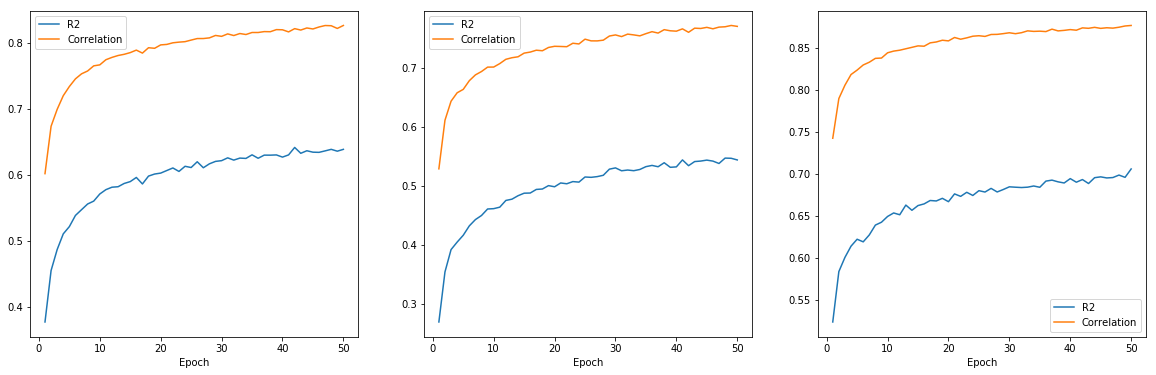

In [9]:
%%time
activation = tf.nn.relu
initializer = None
regularizer = None
epochs = 50
batch_size = 1000
val_split = 0.2
size = 3
num_files = 10

datasets = ["Heat_1", "Heat_2", "Heat_3"]
results = {}
i = 1
k = 1
os.chdir(path+"/Saved_Models_2Sets")
print("Box size used: " + str((2 * size + 1, 2 * size + 1, 2 * size + 1, 3)))
fig = plt.figure(figsize = (20, 6))
for name in datasets:
    x_test = []
    y_test = []
    print("\nPredicting " + name)
    input_shape = (2 * size + 1, 2 * size + 1, 2 * size + 1, 3)
    neural_net = DNN(activation, initializer, regularizer, input_shape)
    model = neural_net.create_model()
    model.compile(optimizer = tf.train.AdamOptimizer(), loss = "mse")
    correlation = []
    R2 = []
    for i in range(epochs):
        temp_1 = []
        temp_2 = []        
        files_range = np.arange(1, num_files * 2 + 1)
        np.random.shuffle(files_range)
        for j in files_range:
            # Load Datasets
            print("\nRunning Dataset:" + name + ": Epoch: " + str(i) + ": fileSet: " + str(j)) 
            x = np.load(path + "/Train_Data/Data/" + str(j) + ".npy")
            y = np.load(path + "/Train_Data/Labels/" + name + "/" + str(j) + ".npy")
            
            # Create Train and Test sets
            mask =  np.random.rand(x.shape[0]) < 0.80
            x_train = x[mask,:,:,:,:]
            y_train = y[mask]
            x_test = x[~mask,:,:,:,:]
            y_test = y[~mask]
            del y
            del mask
            gc.collect()

            model.fit(x_train, y_train, epochs = 1, validation_split = 0.2, batch_size = batch_size, verbose = 1)
            del x_train
            del y_train
            gc.collect()
            
            # Get Test corr and R2 and append to list
            y_pred = model.predict(x_test).flatten()
            gc.collect()
            y_true = y_test.flatten()
            temp_1.append(r2_score(y_true, y_pred))
            temp_2.append(np.corrcoef(y_pred, y_true)[0, 1])
            del x_test
            del y_test
            del x
            gc.collect()
            #i += 1
        
        # Get average Test corr and R2 for the epoch
        correlation.append(np.mean(temp_2))
        R2.append(np.mean(temp_1))
    
    #save model
    model_name_json = "model2_" + name + ".json"
    model_name_h5 = "model2_" + name + ".h5"
    model_json = model.to_json()
    with open(model_name_json, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(model_name_h5)
    print("Saved model to disk\n")
    
    # Plot R2 and corr evolution
    fig.add_subplot(1, len(datasets), k)
    plt.plot(np.arange(1, epochs + 1), np.array(R2), label = 'R2')
    plt.plot(np.arange(1, epochs + 1), np.array(correlation), label = 'Correlation')
    plt.xlabel('Epoch')
    plt.legend()
    print("Final Dataset Correlation: %.4f" % np.corrcoef(y_pred, y_true)[0, 1])
    del y_pred
    del y_true
    gc.collect()
    
    k += 1

In [10]:
os.chdir(path+"/Saved_Models_2Sets")
##### Load Model for tau_12
json_file = open('model2_Heat_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_12 = model_from_json(loaded_model_json)

# load weights into new model
loaded_model_12.load_weights("model2_Heat_1.h5")
print("Loaded model 12 from disk")

# evaluate loaded model on test data 
# Define X_test & Y_test data first
loaded_model_12.compile(optimizer = tf.train.AdamOptimizer(), loss = "mse")

#### Load Model for tau_13
json_file = open('model2_Heat_2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_13 = model_from_json(loaded_model_json)

# load weights into new model
loaded_model_13.load_weights("model2_Heat_2.h5")
print("Loaded model 13 from disk")

# evaluate loaded model on test data 
# Define X_test & Y_test data first
loaded_model_13.compile(optimizer = tf.train.AdamOptimizer(), loss = "mse")

#### Load Model for tau_23
json_file = open('model2_Heat_3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_23 = model_from_json(loaded_model_json)

# load weights into new model
loaded_model_23.load_weights("model2_Heat_3.h5")
print("Loaded model 23 from disk")

# evaluate loaded model on test data 
# Define X_test & Y_test data first
loaded_model_23.compile(optimizer = tf.train.AdamOptimizer(), loss = "mse")

Loaded model 12 from disk
Loaded model 13 from disk
Loaded model 23 from disk


In [11]:
import math
from IPython.display import HTML, display
import tabulate
out = [["Data Source", "Result", "Heat_1", "Heat_2", "Heat_3"]]
dirs = [("Re15sh2_DNScoarse8",8),("Re15sh5_DNScoarse8",8),("Re15sh20_DNScoarse8",8)]
for (dataDir, coarse) in dirs:
    dirName = path + "/Data/" + dataDir
    os.chdir(dirName)
    print("Processing " + dirName)
    u = preprocess(scale(loadmat('u_F_xyz_T1_DNS'+str(coarse)+'.mat')["u_F"]))
    v = preprocess(scale(loadmat('v_F_xyz_T1_DNS'+str(coarse)+'.mat')["v_F"]))
    w = preprocess(scale(loadmat('w_F_xyz_T1_DNS'+str(coarse)+'.mat')["w_F"]))
    tau_12 = preprocess(scale(loadmat('Heat1_F_xyz_T1_DNS'+str(coarse)+'.mat')["Heat1"]))
    tau_13 = preprocess(scale(loadmat('Heat2_F_xyz_T1_DNS'+str(coarse)+'.mat')["Heat2"]))
    tau_23 = preprocess(scale(loadmat('Heat3_F_xyz_T1_DNS'+str(coarse)+'.mat')["Heat3"]))

    x = np.array([u, v, w])
    x = np.transpose(x, [1, 2, 3, 0])
    x = np.pad(x, ((3,3), (3,3), (3,3), (0,0)), 'constant', constant_values = 0)

    sample = []
    size = 3
    y_tau_12 = []
    y_tau_13 = []
    y_tau_23 = []
    for i in tqdm_notebook(range(size, x.shape[0] - size)):
        for j in range(size, x.shape[1] - size):
            for k in range(size, x.shape[2] - size):
                sample.append(x[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
                y_tau_12.append(tau_12[i - size][j - size][k - size])
                y_tau_13.append(tau_13[i - size][j - size][k - size])
                y_tau_23.append(tau_23[i - size][j - size][k - size])
            
    x = np.array(sample)
    y_tau_12 = np.array(y_tau_12)
    y_tau_13 = np.array(y_tau_13)
    y_tau_23 = np.array(y_tau_23)
    
    
    print("predicting Heat_1")
    y_pred_12 = loaded_model_12.predict(x).flatten()


    print("predicting Heat_2")
    y_pred_13 = loaded_model_13.predict(x).flatten()


    print("predicting Heat_3")
    y_pred_23 = loaded_model_23.predict(x).flatten()

    out.append([dataDir, 'Corr', str(np.round(np.corrcoef(y_pred_12, y_tau_12)[0, 1], 4)), str(np.round(np.corrcoef(y_pred_13, y_tau_13)[0, 1], 4)), str(np.round(np.corrcoef(y_pred_23, y_tau_23)[0, 1], 4))])
    out.append(['', 'R^2', str(np.round(r2_score(y_tau_12, y_pred_12), 4)), str(np.round(r2_score(y_tau_13, y_pred_13), 4)), str(np.round(r2_score(y_tau_23, y_pred_23), 4))])
    
display(HTML(tabulate.tabulate(out, tablefmt = 'html')))

Processing /home/llin2948/dscaptstone/Data/Re15sh2_DNScoarse8



predicting Heat_1
predicting Heat_2
predicting Heat_3
Processing /home/llin2948/dscaptstone/Data/Re15sh5_DNScoarse8



predicting Heat_1
predicting Heat_2
predicting Heat_3
Processing /home/llin2948/dscaptstone/Data/Re15sh20_DNScoarse8



predicting Heat_1
predicting Heat_2
predicting Heat_3


Data Source,Result,Heat_1,Heat_2,Heat_3
Re15sh2_DNScoarse8,Corr,0.7382,0.7492,0.8694
,R^2,0.4908,0.5054,0.6947
Re15sh5_DNScoarse8,Corr,0.5807,0.6226,0.7684
,R^2,0.322,0.3696,0.5412
Re15sh20_DNScoarse8,Corr,0.8849,0.7688,0.8471
,R^2,0.7097,0.5392,0.6594
